# Targets: Using Machine Learning Classification Models to Identify Salient Predictors of Cannabis Arrests in New York City, 2006-2018

# Machine Learning Notebook for Classification Models Part III

This notebook continues the work done in Part I and II, this time focusing on building the best classification model to help differentiate felony cannabis possession from the four other types of cannabis crime in New York City between 2006-2018: misdemeanor possession, violation possession, misdemeanor sales, and felony sales. This notebook continues to explore the line between cannabis possession and sales crimes at a greater level of granularity, while aiming to discover the most salient coefficients of the classification models to uncover the features of the dataset with the strongest relationship to felony cannabis possession.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import pickle
from sklearn.utils import resample

In [2]:
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1296)

A flow chart of the machine learning pipeline for classifying felony possession crimes from all other cannabis crimes in New York City between 2006 and 2018 is visualized below. The final outcome of which algorithm performed best is included in this visualization.

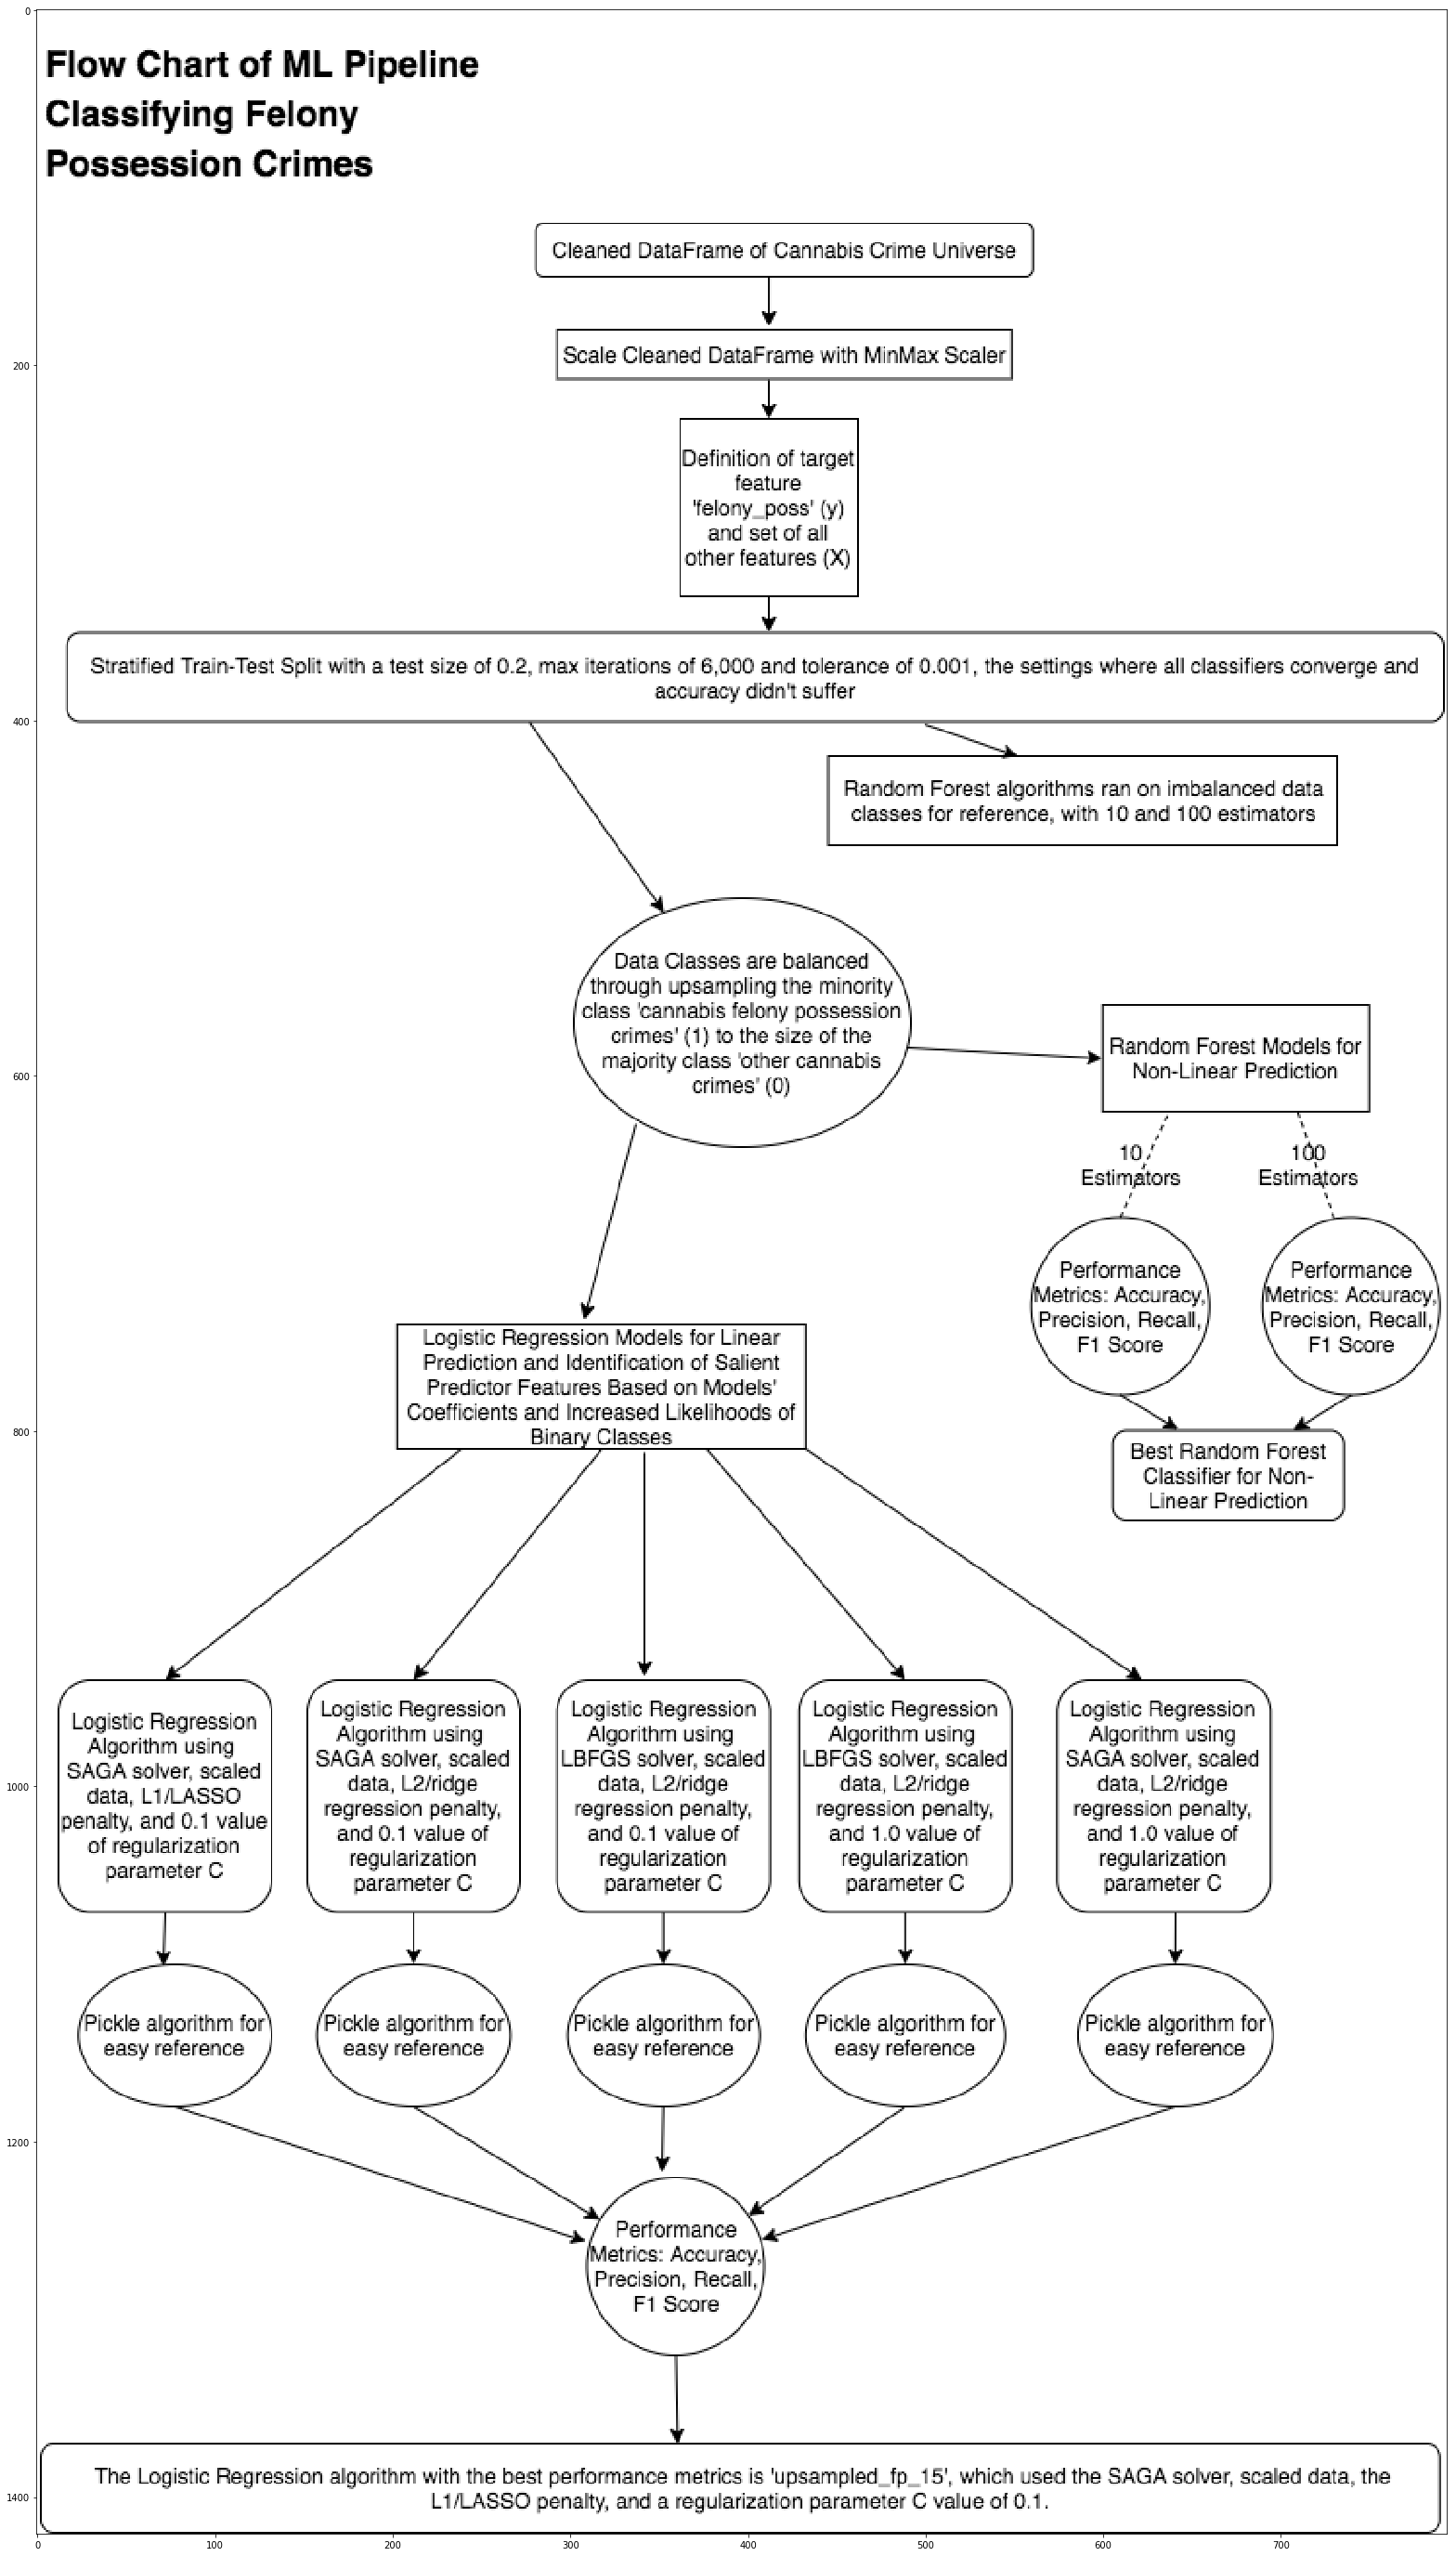

In [3]:
plt.rcParams["figure.figsize"] = (150, 50)
im = plt.imread("Felony Possession ML Pipeline.png")
implot = plt.imshow(im)

The DataFrame of all 220,304 cannabis crimes is loaded into the 'df' DataFrame, and its shape is called for reference.

In [3]:
df = pd.read_csv('nyc_cann_for_ml.csv', index_col=0)

In [4]:
df.shape

(220304, 1302)

# Felony Possession Crimes

The felony possession cases have a value of '1' in the 'felony_poss' feature, and all other cannabis crimes have a value of '0'. Because this round of classification is focused on felony possession cannabis crimes versus all other cannabis crimes, a series of features that also describe the type of crime must be dropped from the DataFrame in order to avoid leakage. These features are dropped in the next cell, which also creates a subsetted DataFrame for use in classifying felony possession crimes. 'CMPLNT_NUM' uniquely identifies each crime, so it is also dropped to avoid leakage (as described in the data cleaning notebook for the creation of the cannabis/non-cannabis DataFrame).

In [45]:
df_fp = df.drop(columns = ['CMPLNT_NUM', 'possession', 'misd_poss', 'viol_poss', 'misd_sales', 'felony_sales'])

In [46]:
df_fp['felony_poss'].value_counts()

0    216549
1      3755
Name: felony_poss, dtype: int64

The .head() method is called on the 'df_fp' DataFrame for reference.

In [70]:
df_fp.head()

,Latitude,Longitude,felony_poss,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),

## Scaling the DataFrame

We now use MinMaxScaler to normalize the data.

In [47]:
scaler = MinMaxScaler()

In [48]:
scaler.fit(df_fp)

/Users/DanLoew/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [49]:
df_fp_scaled = pd.DataFrame(scaler.transform(df_fp), columns=df_fp.columns, index=df_fp.index)

In [10]:
df_fp_scaled.head()

,Latitude,Longitude,felony_poss,duration_days,start_year,start_month,start_day,start_hour,start_minute,start_seconds,rpt_cmplnt_dt_match,day_tw,night_tw,early_morn,morn_rush_hr,work_day,lunch_hr,eve_rush_hr,dinner,evening,late_night,new_years_day,valentines,st_patricks,four_twenty,july_4th,halloween,christmas_eve,christmas,new_years_eve,mlk,pres,easter,diwali,pr_parade,yomkippur,rosh_hashanah,eid_al_fitr,eid_al_adha,hanukkah,memorial_day,labor_day,thanksgiving,closest_subway_distance_l1,closest_subway_distance_l2,wtc_l1,nyse_l1,bk_bridge_l1,city_hall_l1,manh_bridge_l1,will_bridge_l1,wash_sq_park_l1,union_sq_l1,penn_station_l1,times_sq_l1,rock_center_l1,empire_st_bldg_l1,lincoln_ctr_l1,central_pk_l1,apollo_th_l1,yankee_stad_l1,mets_stad_l1,queens_l1,prospect_pk_l1,downtown_bk_l1,si_ferry_l1,port_authority_l1,nypd_hq_l1,mdc_l1,rikers_l1,nysc_l1,wtc_l2,nyse_l2,bk_bridge_l2,city_hall_l2,manh_bridge_l2,will_bridge_l2,wash_sq_park_l2,union_sq_l2,penn_station_l2,times_sq_l2,rock_center_l2,empire_st_bldg_l2,lincoln_ctr_l2,central_pk_l2,apollo_th_l2,yankee_stad_l2,mets_stad_l2,queens_l2,prospect_pk_l2,downtown_bk_l2,si_ferry_l2,port_authority_l2,nypd_hq_l2,mdc_l2,rikers_l2,nysc_l2,ADDR_PCT_CD_1.0,ADDR_PCT_CD_5.0,ADDR_PCT_CD_6.0,ADDR_PCT_CD_7.0,ADDR_PCT_CD_9.0,ADDR_PCT_CD_10.0,ADDR_PCT_CD_13.0,ADDR_PCT_CD_14.0,ADDR_PCT_CD_17.0,ADDR_PCT_CD_18.0,ADDR_PCT_CD_19.0,ADDR_PCT_CD_20.0,ADDR_PCT_CD_22.0,ADDR_PCT_CD_23.0,ADDR_PCT_CD_24.0,ADDR_PCT_CD_25.0,ADDR_PCT_CD_26.0,ADDR_PCT_CD_28.0,ADDR_PCT_CD_30.0,ADDR_PCT_CD_32.0,ADDR_PCT_CD_33.0,ADDR_PCT_CD_34.0,ADDR_PCT_CD_40.0,ADDR_PCT_CD_41.0,ADDR_PCT_CD_42.0,ADDR_PCT_CD_43.0,ADDR_PCT_CD_44.0,ADDR_PCT_CD_45.0,ADDR_PCT_CD_46.0,ADDR_PCT_CD_47.0,ADDR_PCT_CD_48.0,ADDR_PCT_CD_49.0,ADDR_PCT_CD_50.0,ADDR_PCT_CD_52.0,ADDR_PCT_CD_60.0,ADDR_PCT_CD_61.0,ADDR_PCT_CD_62.0,ADDR_PCT_CD_63.0,ADDR_PCT_CD_66.0,ADDR_PCT_CD_67.0,ADDR_PCT_CD_68.0,ADDR_PCT_CD_69.0,ADDR_PCT_CD_70.0,ADDR_PCT_CD_71.0,ADDR_PCT_CD_72.0,ADDR_PCT_CD_73.0,ADDR_PCT_CD_75.0,ADDR_PCT_CD_76.0,ADDR_PCT_CD_77.0,ADDR_PCT_CD_78.0,ADDR_PCT_CD_79.0,ADDR_PCT_CD_81.0,ADDR_PCT_CD_83.0,ADDR_PCT_CD_84.0,ADDR_PCT_CD_88.0,ADDR_PCT_CD_90.0,ADDR_PCT_CD_94.0,ADDR_PCT_CD_100.0,ADDR_PCT_CD_101.0,ADDR_PCT_CD_102.0,ADDR_PCT_CD_103.0,ADDR_PCT_CD_104.0,ADDR_PCT_CD_105.0,ADDR_PCT_CD_106.0,ADDR_PCT_CD_107.0,ADDR_PCT_CD_108.0,ADDR_PCT_CD_109.0,ADDR_PCT_CD_110.0,ADDR_PCT_CD_111.0,ADDR_PCT_CD_112.0,ADDR_PCT_CD_113.0,ADDR_PCT_CD_114.0,ADDR_PCT_CD_115.0,ADDR_PCT_CD_120.0,ADDR_PCT_CD_121.0,ADDR_PCT_CD_122.0,ADDR_PCT_CD_123.0,BORO_NM_BRONX,BORO_NM_BROOKLYN,BORO_NM_MANHATTAN,BORO_NM_QUEENS,BORO_NM_STATEN ISLAND,BORO_NM_unknown,LOC_OF_OCCUR_DESC_FRONT OF,LOC_OF_OCCUR_DESC_INSIDE,LOC_OF_OCCUR_DESC_OPPOSITE OF,LOC_OF_OCCUR_DESC_REAR OF,LOC_OF_OCCUR_DESC_unknown,PREM_TYP_DESC_ABANDONED BUILDING,PREM_TYP_DESC_AIRPORT TERMINAL,PREM_TYP_DESC_ATM,PREM_TYP_DESC_BANK,PREM_TYP_DESC_BAR/NIGHT CLUB,PREM_TYP_DESC_BEAUTY & NAIL SALON,PREM_TYP_DESC_BOOK/CARD,PREM_TYP_DESC_BRIDGE,PREM_TYP_DESC_BUS (NYC TRANSIT),PREM_TYP_DESC_BUS (OTHER),PREM_TYP_DESC_BUS STOP,PREM_TYP_DESC_BUS TERMINAL,PREM_TYP_DESC_CANDY STORE,PREM_TYP_DESC_CEMETERY,PREM_TYP_DESC_CHAIN STORE,PREM_TYP_DESC_CHECK CASHING BUSINESS,PREM_TYP_DESC_CHURCH,PREM_TYP_DESC_CLOTHING/BOUTIQUE,PREM_TYP_DESC_COMMERCIAL BUILDING,PREM_TYP_DESC_CONSTRUCTION SITE,PREM_TYP_DESC_DEPARTMENT STORE,PREM_TYP_DESC_DOCTOR/DENTIST OFFICE,PREM_TYP_DESC_DRUG STORE,PREM_TYP_DESC_DRY CLEANER/LAUNDRY,PREM_TYP_DESC_FACTORY/WAREHOUSE,PREM_TYP_DESC_FAST FOOD,PREM_TYP_DESC_FERRY/FERRY TERMINAL,PREM_TYP_DESC_FOOD SUPERMARKET,PREM_TYP_DESC_GAS STATION,PREM_TYP_DESC_GROCERY/BODEGA,PREM_TYP_DESC_GYM/FITNESS FACILITY,PREM_TYP_DESC_HIGHWAY/PARKWAY,PREM_TYP_DESC_HOSPITAL,PREM_TYP_DESC_HOTEL/MOTEL,PREM_TYP_DESC_JEWELRY,PREM_TYP_DESC_LIQUOR STORE,PREM_TYP_DESC_MARINA/PIER,PREM_TYP_DESC_OPEN AREAS (OPEN LOTS),PREM_TYP_DESC_OTHER,PREM_TYP_DESC_OTHER HOUSE OF WORSHIP,PREM_TYP_DESC_PARK/PLAYGROUND,PREM_TYP_DESC_PARKING LOT/GARAGE (PRIVATE),PREM_TYP_DESC_PARKING LOT/GARAGE (PUBLIC),

The target feature in this series of classifications is the binary feature 'felony_poss', with a value of 1 for felony possession cannabis crimes and 0 for all other cannabis crimes. The target feature is assigned to y.

In [50]:
y = df_fp_scaled['felony_poss']

The feature set is assigned to X, which includes all features in the 'df_fp_scaled' DataFrame which are not the target.

In [51]:
target_names = ['felony_poss']
X = df_fp_scaled[[cn for cn in df_fp_scaled.columns if cn not in target_names]]

## Training and Test Data Split

In order to find the best model that can generalize to unseen data, the DataFrame is split into training and test sets. 

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

## Random Forest Algorithm

The Random Forest classifier is carried out on the violation possession crimes below on the original training set as an experiment, first with 10 estimators and then 100.

In [196]:
rfc_fp_1 = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [197]:
rfc_fp_pred_1 = rfc_fp_1.predict(X_test)

In [198]:
accuracy_score(y_test, rfc_fp_pred_1)

0.9823653571185402

The confusion matrix shows that there are 43,264 true positives, 731 false positives, 46 false negatives, and 20 true negatives.

In [199]:
confusion_matrix(y_test, rfc_fp_pred_1)

array([[43264,    46],
       [  731,    20]])

In [200]:
print(classification_report(y_test, rfc_fp_pred_1))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     43310
         1.0       0.30      0.03      0.05       751

   micro avg       0.98      0.98      0.98     44061
   macro avg       0.64      0.51      0.52     44061
weighted avg       0.97      0.98      0.98     44061



In [201]:
filename = 'rfc_fp_1.sav'
pickle.dump(rfc_fp_1, open(filename, 'wb'))

The accuracy and weighted averages for precision, recall, and F1 score are all quite high, but the model is much worse at predicting felony possession cannabis crimes than the other types of cannabis crimes. This is to be expected with imbalanced data classes to some extent, but makes the case for upsampling the minority class.

In [203]:
rfc_fp_2 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [204]:
rfc_fp_pred_2 = rfc_fp_2.predict(X_test)

In [205]:
accuracy_score(y_test, rfc_fp_pred_2)

0.9827057942398039

The confusion matrix shows that there are 43,280 true positives, 732 false positives, 30 false negatives, and 19 true negatives.

In [206]:
confusion_matrix(y_test, rfc_fp_pred_2)

array([[43280,    30],
       [  732,    19]])

In [207]:
print(classification_report(y_test, rfc_fp_pred_2))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     43310
         1.0       0.39      0.03      0.05       751

   micro avg       0.98      0.98      0.98     44061
   macro avg       0.69      0.51      0.52     44061
weighted avg       0.97      0.98      0.98     44061



In [208]:
filename = 'rfc_fp_2.sav'
pickle.dump(rfc_fp_2, open(filename, 'wb'))

The RandomForest classifier does perform slightly better 100 estimators than 10 estimators, but only with precision for felony possession crimes. 

## Upsampling the Minority Class in the Training Set

First, the training data is concatenated back together.

In [53]:
X = pd.concat([X_train, y_train], axis=1)

Then, the minority and majority classes are separated.

In [54]:
not_felony_poss = X[X.felony_poss == 0]
felony_poss = X[X.felony_poss == 1]

Then, the minority class (i.e., viol_poss) is upsampled.

In [55]:
felony_poss_upsampled = resample(felony_poss,
                          replace=True, # sample with replacement
                          n_samples=len(not_felony_poss), # match number in majority class
                          random_state=27) # reproducible results

Then, the majority and upsampled minority classes are combined.

In [56]:
upsampled_fp = pd.concat([not_felony_poss, felony_poss_upsampled])

The new class counts are checked.

In [57]:
upsampled_fp.felony_poss.value_counts()

1.0    173239
0.0    173239
Name: felony_poss, dtype: int64

The 'y_train' target and 'X_train' feature set are then re-defined.

In [58]:
y_train = upsampled_fp.felony_poss

In [59]:
X_train = upsampled_fp.drop('felony_poss', axis=1)

## Using the Best Performing Algorithms

In order to tune the hyperparameters, the top 5 performing LogisticRegression algorithms from the Part II possession vs. sales classification are run. The numbering scheme from Part II is maintained (with the addition of the suffix '_fp'), for ease of reference.

In [60]:
upsampled_fp_15 = linear_model.LogisticRegression(penalty='l1', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [61]:
upsampled_fp_pred_15 = upsampled_fp_15.predict(X_test)
upsampled_fp_pred_15[0:35]

array([1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1.])

In [87]:
accuracy_score(y_test, upsampled_fp_pred_15)

0.7357754022831983

The confusion matrix shows that there are 31,915 true positives, 247 false positives, 11,395 false negatives, and 504 true negatives.

In [88]:
confusion_matrix(y_test, upsampled_fp_pred_15)

array([[31915, 11395],
       [  247,   504]])

In [89]:
print(classification_report(y_test, upsampled_fp_pred_15))

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85     43310
         1.0       0.04      0.67      0.08       751

   micro avg       0.74      0.74      0.74     44061
   macro avg       0.52      0.70      0.46     44061
weighted avg       0.98      0.74      0.83     44061



In [222]:
filename = 'upsampled_fp_15.sav'
pickle.dump(upsampled_fp_15, open(filename, 'wb'))

In [223]:
upsampled_fp_9 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [224]:
upsampled_fp_pred_9 = upsampled_fp_9.predict(X_test)
upsampled_fp_pred_9[0:35]

array([1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1.])

In [225]:
accuracy_score(y_test, upsampled_fp_pred_9)

0.7354122693538503

The confusion matrix shows that there are 31,899 true positives, 247 false positives, 11,411 false negatives, and 504 true negatives.

In [226]:
confusion_matrix(y_test, upsampled_fp_pred_9)

array([[31899, 11411],
       [  247,   504]])

In [227]:
print(classification_report(y_test, upsampled_fp_pred_9))

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85     43310
         1.0       0.04      0.67      0.08       751

   micro avg       0.74      0.74      0.74     44061
   macro avg       0.52      0.70      0.46     44061
weighted avg       0.98      0.74      0.83     44061



In [228]:
filename = 'upsampled_fp_9.sav'
pickle.dump(upsampled_fp_9, open(filename, 'wb'))

In [229]:
upsampled_fp_1 = linear_model.LogisticRegression(penalty='l2', C=0.1, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [230]:
upsampled_fp_pred_1 = upsampled_fp_1.predict(X_test)
upsampled_fp_pred_1[0:35]

array([1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1.])

In [231]:
accuracy_score(y_test, upsampled_fp_pred_1)

0.7354803567781031

The confusion matrix shows that there are 31,902 true positives, 247 false positives, 11,408 false negatives, and 504 true negatives.

In [232]:
confusion_matrix(y_test, upsampled_fp_pred_1)

array([[31902, 11408],
       [  247,   504]])

In [233]:
print(classification_report(y_test, upsampled_fp_pred_1))

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85     43310
         1.0       0.04      0.67      0.08       751

   micro avg       0.74      0.74      0.74     44061
   macro avg       0.52      0.70      0.46     44061
weighted avg       0.98      0.74      0.83     44061



In [234]:
filename = 'upsampled_fp_1.sav'
pickle.dump(upsampled_fp_1, open(filename, 'wb'))

In [235]:
upsampled_fp_4 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='lbfgs', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [236]:
upsampled_fp_pred_4 = upsampled_fp_4.predict(X_test)
upsampled_fp_pred_4[0:35]

array([1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1.])

In [237]:
accuracy_score(y_test, upsampled_fp_pred_4)

0.7351399196568393

The confusion matrix shows that there are 31,889 true positives, 249 false positives, 11,421 false negatives, and 502 true negatives.

In [238]:
confusion_matrix(y_test, upsampled_fp_pred_4)

array([[31889, 11421],
       [  249,   502]])

In [239]:
print(classification_report(y_test, upsampled_fp_pred_4))

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85     43310
         1.0       0.04      0.67      0.08       751

   micro avg       0.74      0.74      0.74     44061
   macro avg       0.52      0.70      0.46     44061
weighted avg       0.98      0.74      0.83     44061



In [240]:
filename = 'upsampled_fp_4.sav'
pickle.dump(upsampled_fp_4, open(filename, 'wb'))

In [241]:
upsampled_fp_10 = linear_model.LogisticRegression(penalty='l2', C=1.0, solver='saga', max_iter=6000, tol=0.001).fit(X_train, y_train)

In [242]:
upsampled_fp_pred_10 = upsampled_fp_10.predict(X_test)
upsampled_fp_pred_10[0:35]

array([1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
       1.])

In [243]:
accuracy_score(y_test, upsampled_fp_pred_10)

0.7350718322325867

The confusion matrix shows that there are 31,886 true positives, 249 false positives, 11,424 false negatives, and 502 true negatives.

In [244]:
confusion_matrix(y_test, upsampled_fp_pred_10)

array([[31886, 11424],
       [  249,   502]])

In [245]:
print(classification_report(y_test, upsampled_fp_pred_10))

              precision    recall  f1-score   support

         0.0       0.99      0.74      0.85     43310
         1.0       0.04      0.67      0.08       751

   micro avg       0.74      0.74      0.74     44061
   macro avg       0.52      0.70      0.46     44061
weighted avg       0.98      0.74      0.83     44061



In [246]:
filename = 'upsampled_fp_10.sav'
pickle.dump(upsampled_fp_10, open(filename, 'wb'))

## Best LogisticRegression Algorithm

The best performing LogisticRegression algorithm is 'upsampled_fp_15', which uses the 'saga' solver, L1 penalty, and a C value of 0.1. This will be used to call the coefficients for the feature set.

## Random Forest Algorithm on Upsampled Training Data

A Random Forest classifier was used on the original training data above, but it is also carried out below on the upsampled training data out of experimental interest. First, 10 estimators, and then 100 estimators are tried.

In [247]:
rfc_fp_3 = RandomForestClassifier(n_estimators=10).fit(X_train, y_train)

In [248]:
rfc_fp_pred_3 = rfc_fp_3.predict(X_test)
rfc_fp_pred_3[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [249]:
accuracy_score(y_test, rfc_fp_pred_3)

0.9798915140373573

The confusion matrix shows that there are 43,142 true positives, 718 false positives, 168 false negatives, and 33 true negatives.

In [250]:
confusion_matrix(y_test, rfc_fp_pred_3)

array([[43142,   168],
       [  718,    33]])

In [251]:
print(classification_report(y_test, rfc_fp_pred_3))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     43310
         1.0       0.16      0.04      0.07       751

   micro avg       0.98      0.98      0.98     44061
   macro avg       0.57      0.52      0.53     44061
weighted avg       0.97      0.98      0.97     44061



In [252]:
filename = 'felony_poss_rfc_3.sav'
pickle.dump(rfc_fp_3, open(filename, 'wb'))

In [253]:
rfc_fp_4 = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)

In [254]:
rfc_fp_pred_4 = rfc_fp_4.predict(X_test)
rfc_fp_pred_4[0:35]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.])

In [255]:
accuracy_score(y_test, rfc_fp_pred_4)

0.9804589092394634

The confusion matrix shows that there are 43,167 true positives, 718 false positives, 143 false negatives, and 33 true negatives.

In [256]:
confusion_matrix(y_test, rfc_fp_pred_4)

array([[43167,   143],
       [  718,    33]])

In [257]:
print(classification_report(y_test, rfc_fp_pred_4))

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     43310
         1.0       0.19      0.04      0.07       751

   micro avg       0.98      0.98      0.98     44061
   macro avg       0.59      0.52      0.53     44061
weighted avg       0.97      0.98      0.97     44061



In [263]:
filename = 'felony_poss_rfc_4.sav'
pickle.dump(rfc_fp_4, open(filename, 'wb'))

## Best Performing Classification Algorithm for Cannabis Felony Possession Crimes

The best performing classification algorithm is the Random Forest algorithm with 100 estimators. The only metric where it is far lower than the 'upsampled_fp_15' LogisticRegression algorithm is recall (or true positive rate) for felony possession crimes (0.04 vs. 0.67). The Random Forest algorithm with 100 estimators performs the best, but the 'upsampled_fp_15' LogisticRegression algorithm will still be used to call the coefficients for the feature set as RandomForest is incapable of doing so, and these coefficients will help highlight the most salient features that differentiate cannabis felony possession crimes from all other cannabis crimes. The hyperparameter tuning table for felony possession crimes and all other cannabis crimes is shown below, for reference.

In [90]:
felony_poss_metrics = pd.read_excel('HP tuning table.xlsx', sheet_name='Felony_Poss')
felony_poss_metrics

,UPSAMPLED,LR_#,Accuracy_Score,Precision_Not_Felony_Poss,Precision_Felony_Poss,Precision_Wtd_Average,Recall_Not_Felony_Poss,Recall_Felony_Poss,Recall_Wtd_Average,F1_Score_Not_Felony_Poss,F1_Score_Felony_Poss,F1_Score_Wtd_Average,Support_Not_Viol_Poss,Support_Viol_Poss,Support_Total
0,"RF, scaled, 100 n_estimators",rfc_fp_pred_4,0.980459,0.98,0.19,0.97,1.00,0.04,0.98,0.99,0.07,0.97,43310.0,751.0,44061.0
1,"RF, scaled, 10 n_estimators",rfc_fp_pred_3,0.979892,0.98,0.16,0.97,1.00,0.04,0.98,0.99,0.07,0.97,43310.0,751.0,44061.0
2,"LR, scaled, saga solver, L1 penalty, C=0.1",upsampled_fp_15,0.735775,0.99,0.04,0.98,0.74,0.67,0.74,0.85,0.08,0.83,43310.0,751.0,44061.0
3,"LR, scaled, lbfgs solver, L2 penalty, C=0.1",upsampled_fp_1,0.735480,0.99,0.04,0.98,0.74,0.67,0.74,0.85,0.08,0.83,43310.0,751.0,44061.0
4,"LR, scaled, saga solver, L2 penalty, C=0.1",upsampled_fp_9,0.735412,0.99,0.04,0.98,0.74,0.67,0.74,0.85,0.08,0.83,43310.0,751.0,44061.0
5,"LR, scaled, lbfgs solver, L2 penalty, C=1.0",upsampled_fp_4,0.735140,0.99,0.04,0.98,0.74,0.67,0.74,0.85,0.08,0.83,43310.0,751.0,44061.0
6,"LR, scaled, saga solver, L2 penalty, C=1.0",upsampled_fp_10,0.735072,0.99,0.04,0.98,0.74,0.67,0.74,0.85,0.08,0.83,43310.0,751.0,44061.0
7,IMBALANCED,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,"RandomForest, 10 estimators",rfc_fp1,0.982365,0.98,0.30,0.97,1.00,0.03,0.98,0.99,0.05,0.98,43310.0,751.0,44061.0
9,"RandomForest, 100 estimators",rfc_fp2,0.982706,0.98,0.39,0.97,1.00,0.03,0.98,0.99,0.05,0.98,43310.0,751.0,44061.0


## ROC curve and AUC

The best Receiver Operating Characteristic (ROC) curve and Area Under the Curve (AUC) are called on both the Random Forest algorithm with 100 estimators, and on the 'upsampled_fp_15' LogisticRegression algorithm. This is done to further evaluate the model.

In [259]:
y_pred_prob_rfc_fp_4 = rfc_fp_4.predict_proba(X_test)[:,1]
y_pred_prob_rfc_fp_4

array([0.02, 0.  , 0.05, ..., 0.03, 0.  , 0.  ])

In [260]:
fpr_rfc_fp_4, tpr_rfc_fp_4, thresholds_rfc_fp_4 = roc_curve(y_test, y_pred_prob_rfc_fp_4)

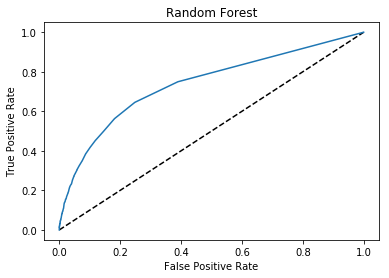

In [261]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rfc_fp_4, tpr_rfc_fp_4, label='Random Forest')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest')
plt.show();

In [262]:
auc_score_rfc_fp_4 = roc_auc_score(y_test, y_pred_prob_rfc_fp_4)
auc_score_rfc_fp_4

0.7385408080536657

In [86]:
y_pred_prob_upsampled_fp_15 = upsampled_fp_15.predict_proba(X_test)[:,1]
y_pred_prob_upsampled_fp_15

array([0.72650471, 0.11496364, 0.62533658, ..., 0.63727683, 0.40936711,
       0.10713126])

In [87]:
fpr_upsampled_fp_15, tpr_upsampled_fp_15, thresholds_upsampled_fp_15 = roc_curve(y_test, y_pred_prob_upsampled_fp_15)

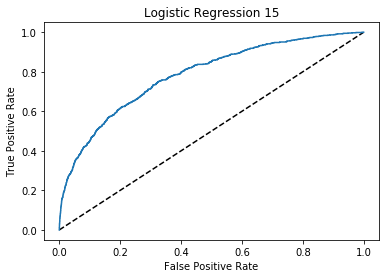

In [88]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_upsampled_fp_15, tpr_upsampled_fp_15, label='Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression 15')
plt.show();

In [89]:
auc_score_upsampled_fp_15 = roc_auc_score(y_test, y_pred_prob_upsampled_fp_15)
auc_score_upsampled_fp_15

0.7840913723593663

The 'upsampled_fp_15' LogisticRegression algorithm has a higher AUC score than the Random Forest classifier with 100 estimators.

## Precision Recall Curve

Because of the imbalanced class count, the 15th LogisticRegression algorithm is evaluated below with a Precision-Recall Curve.

The precision recall curve is defined below, as is the F1 score and AUC for the precision-recall curve.

In [90]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred_prob_upsampled_fp_15)

In [91]:
lr_fp_f1, lr_fp_auc = f1_score(y_test, upsampled_fp_pred_15), auc(lr_recall, lr_precision)

The scores are then summarized.

In [92]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_fp_f1, lr_fp_auc))

Logistic: f1=0.080 auc=0.110


The precision-recall curve is then plotted for the best Logistic Regression algorithm. The precision-recall curve's AUC is very low, showing that the model does not have a good harmonic average of precision and recall for felony possession crimes but is moderately skillful at predicting other cannabis crimes as a group.

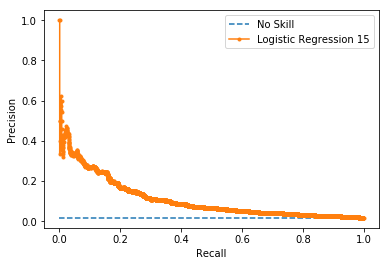

In [93]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic Regression 15')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

## Evaluation of the Classification Models for Felony Possession

The best LogisticRegression model ('upsampled_fp_15') has an accuracy of 0.735775402283198, showing that it makes correct predictions on roughly 73.6% of the data points in the DataFrame.

The model's precision is 0.04 for the felony possession class (the 1 class), 0.99 for the other cannabis crime types class (the 0 class), and 0.98 on weighted average, showing that 4% of predicted felony possession crimes are actual felony possession crimes, 99% of predicted other cannabis crimes are actual other cannabis crimes, and 98% of crimes on weighted average are predicted correctly. 

The model's recall is 0.67 for the felony possession class (the 1 class), 0.74 for the other cannabis crime types class (0), and 0.74 on weighted average, showing that 67% of actual felony possession crimes are predicted as felony possession crimes, 74% of actual other cannabis crimes are predicted as other cannabis crimes, and that 74% of crimes on weighted average are predicted correctly.

The model's F1 score, or harmonic mean of precision and recall, is 0.08 for the felony possession class, 0.85 for the other cannabis crimes class, and 0.83 on weighted average. This metric is more informative than precision or recall alone, and shows that only 8% of felony possession crimes and 85% of other cannabis crimes are being predicted correctly, for a weighted average of 83%.

The ROC curves plotted above show that the best LogisticRegression model ('upsampled_fp_15') has an ROC AUC score of 78.4%, showing that it is a moderately skillful model in predicting felony possession crimes at a rate higher than random. The Precision Recall Curve has an AUC score of 11.1%. The very low Precision Recall AUC score shows that the model is not very skilled at differentiating true positives from false positives and false negatives for the felony possession class. However, as is shown above, it is more skillful at predicting the other cannabis crime types as a group.

The RandomForest model with 100 estimators has an accuracy of 0.980458909239463. It has a 0.19 precision score for the felony possession class, a 0.98 precision score for the other crime types class, and a weighted average precision score of 0.97. The model has a recall score of 0.04 for the felony possession class, a 1.0 recall score for the other crime types class, and a weighted average recall score of 0.98. It has a 0.07 F1 score for the felony possession class, a 0.99 F1 score for the other crime types class, and a weighted average F1 score of 0.97. The ROC curve plotted above shows that it has an AUC score of 73.9%. This is a very unskillful model at predicting felony possession crimes. 

## Coefficients for Felony Possession

As detailed above, the F1 score for the felony possession class is only 0.08 when using the best performing Logistic Regression algorithm 'upsampled_fp_15'. However, the coefficients can still be valuable in identifying salient features of felony possession crimes to a certain degree if the F1 score is higher than zero. The only scenario where the coefficients would definitely not be valuable is if the algorithm only or almost only predicts one class. To check on whether the algorithm predicts both classes, and not just one, the predicted values 'upsampled_fp_pred_15' are converted to a Pandas Series and then its value counts are called. As can be seen, the felony possession class is predicted 11,899 times and the other cannabis crime types as a group are predicted 32,162 times. Therefore, the coefficients for the felony possession class are valuable and are called and analyzed below.

In [23]:
upsampled_fp_pred_15_s = pd.Series(upsampled_fp_pred_15)
upsampled_fp_pred_15_s.value_counts()

0.0    32162
1.0    11899
dtype: int64

In order to look at the most salient predictors of cannabis felony possession crimes in New York City between 2006-2018, the feature set's coefficients for the best performing Logistic Regression algorithm ('upsampled_fp_15') are identified to find the most predictive features differentiating cannabis felony  possession crimes from all other cannabis crimes.

First, the coefficients are called for all the features in the feature set, assigned to 'best_cf_fp_coeffs' (short for 'best classifier's coefficients').

In [62]:
best_cf_fp_coeffs = pd.Series(upsampled_fp_15.coef_[0], index=X_train.columns) 
best_cf_fp_coeffs

Latitude                                                                        1.128529
Longitude                                                                       0.000000
duration_days                                                                   0.000000
start_year                                                                      0.139514
start_month                                                                    -0.035059
start_day                                                                       0.120937
start_hour                                                                     -0.296082
start_minute                                                                   -0.291373
start_seconds                                                                   0.000000
rpt_cmplnt_dt_match                                                            -0.644998
day_tw                                                                          0.000000
night_tw             

The features' coefficients are then sorted to show the features most predictive of cannabis felony possession crimes. The features with positive coefficients are more predictive of felony possession crimes, while the features with negative coefficients are more predictive of all other cannabis crimes. Because the '0' class, i.e. "all other cannabis crimes", is non-differentiated, there is no real value to the negative coefficients and they will be ignored.

In [63]:
sorted_best_cf_fp_coeffs = best_cf_fp_coeffs.sort_values()
sorted_best_cf_fp_coeffs

mdc_l1                                                                         -5.144362
PREM_TYP_DESC_PARK/PLAYGROUND                                                  -3.890261
PREM_TYP_DESC_PUBLIC SCHOOL                                                    -2.986266
PREM_TYP_DESC_BUS TERMINAL                                                     -2.970991
will_bridge_l2                                                                 -2.961226
HADEVELOPT_WILLIAMSBURG                                                        -2.753562
PREM_TYP_DESC_MARINA/PIER                                                      -2.619378
PREM_TYP_DESC_CANDY STORE                                                      -2.543053
JURIS_DESC_N.Y. TRANSIT POLICE                                                 -2.388022
SUSP_AGE_GROUP_cleaned_<18                                                     -2.158616
JURIS_DESC_POLICE DEPT NYC                                                     -1.940601
ADDR_PCT_CD_18.0     

To look at which features have the strongest relationship to felony possession, the features that have at least a 0.7209657 coefficient are called and speculated on below by assigning the object 'sorted_best_cf_fp_coeffs'. When exponentiated by assigning the object 'cannabis_fp_coeffs_lls', these features are shown to provide at least a 2% increase in the odds of a crime being a felony possession crime.

In [64]:
cannabis_fp_coeffs = sorted_best_cf_fp_coeffs[-103:].sort_values(ascending=False)
cannabis_fp_coeffs

PARKS_NM_CANARSIE PARK                                6.997627
STATION_NAME_47-50 STS./ROCKEFELLER CTR.              6.322967
STATION_NAME_W. 4 STREET                              5.236832
STATION_NAME_GATES AVENUE                             4.985308
STATION_NAME_25 STREET                                4.476420
STATION_NAME_241 ST.-WAKEFIELD                        4.227127
downtown_bk_l1                                        3.887497
STATION_NAME_207 ST.-INWOOD                           3.550997
STATION_NAME_NEWKIRK AVENUE                           3.407409
HADEVELOPT_BARUCH HOUSES ADDITION                     3.291727
PREM_TYP_DESC_HOTEL/MOTEL                             2.977399
PREM_TYP_DESC_TAXI (LIVERY LICENSED)                  2.898674
HADEVELOPT_SOUTHERN BOULEVARD                         2.769328
HADEVELOPT_HOWARD AVENUE-PARK PLACE                   2.690085
STATION_NAME_205 ST.-NORWOOD                          2.637736
HADEVELOPT_UNITY PLAZA (SITES 4-27)                   2

In [35]:
cannabis_fp_coeffs_lls = np.array(np.exp(cannabis_fp_coeffs))
cannabis_fp_coeffs_lls

array([1093.50906455,  557.21828017,  188.0581737 ,  146.24818511,
         87.92283081,   68.5226641 ,   48.83724104,   34.84869891,
         30.18643301,   26.88884617,   19.63590064,   18.14932988,
         15.94700259,   14.73333799,   13.98211255,   13.76860841,
         11.94689461,   11.69770135,   11.4513424 ,   11.32949154,
         10.70953191,    8.82937451,    8.20289379,    8.19331187,
          7.98973888,    7.66256385,    7.54192546,    7.47938054,
          7.3920566 ,    7.28641072,    7.13290715,    7.04440736,
          7.02752456,    6.60545331,    6.40183183,    6.11511415,
          5.86145983,    5.44511464,    5.37327882,    4.9878765 ,
          4.87744886,    4.79714947,    4.77514213,    4.74072753,
          4.73152452,    4.70203989,    4.69905871,    4.69197992,
          4.65592537,    4.60328753,    4.59070532,    4.57302984,
          4.53461317,    4.49205536,    4.46484349,    4.30129409,
          4.14957422,    4.02212461,    3.87969755,    3.87596

## Feature Set Coefficients and Likelihoods for Felony Possession

The features, their coefficients, and the increased likelihood towards felony possession crime are called in an Excel table below.

In [37]:
fp_coeffs_lls_table = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fp_coeffs')
fp_coeffs_lls_table

,Feature,Coefficient,Increased Odds Towards Felony Possession Class
0,PARKS_NM_CANARSIE PARK,6.997147,1093.509065
1,STATION_NAME_47-50 STS./ROCKEFELLER CTR.,6.322957,557.218280
2,STATION_NAME_W. 4 STREET,5.236751,188.058174
3,STATION_NAME_GATES AVENUE,4.985305,146.248185
4,STATION_NAME_25 STREET,4.476460,87.922831
5,STATION_NAME_241 ST.-WAKEFIELD,4.227165,68.522664
6,downtown_bk_l1,3.888493,48.837241
7,STATION_NAME_207 ST.-INWOOD,3.551016,34.848699
8,STATION_NAME_NEWKIRK AVENUE,3.407393,30.186433
9,HADEVELOPT_BARUCH HOUSES ADDITION,3.291712,26.888846


The specific premises features with the highest coefficients show that felony possession arrests have the strongest relationship with hotels and motels, livery licensed taxis, drug stores, shoe stores, storage facilities, unclassified stores, yellow licensed taxis, commercial buildings, unlicensed livery taxis, variety stores, residential houses, beauty and nail salons, and telecomm stores, in descending order of increased likelihood. The increased likelihood of a cannabis crime being a felony possession crime for these features range from 2% to 20%, with hotels and motels having a 20% increased likelihood, livery licensed taxis having a 18% increased likelihood, and the other premise types ranging from 2% to 8% increased likelihood. This suggests that felony possession with intent to distribute is occurring inside of legitimate businesses as a side business, and that hotels/motels and livery licensed taxis are the most common premises where felony possession occurs. On a related note, "inside" of these premises is where felony possession arrests most often occur, denoted by the coefficient of 0.71 and increased likelihood of 2% for the "LOC_OF_OCCUR_DESC_INSIDE" feature.

There is interestingly only one NYC park that has a strong relationship with felony possession charges, and that is Canarsie Park in the Canarsie neighborhood of Eastern Brooklyn. This park has a coefficient of 7, and an increased likelihood of a cannabis arrest being a felony possession arrest of 1,094%! This park was obviously the site of many felony possession arrests and was likely connected in some way to a major distribution hub.

Felony possession arrests have several strong relationships with specific subway/transit stations. These include (in descending order of coefficients and likelihoods):

- 47-50 Sts./Rockefeller Center in Midtown Manhattan (557% increased likelihood), 

- W. 4th Street in the East Village (188% increased likelihood), 

- Gates Avenue in the Bushwick neighborhood of Northern Brooklyn (146% increased likelihood), 

- 25th Street in the South Slope neighborhood of Southern Brooklyn (88% increased likelihood), 

- 241st St.-Wakefield in the Northern Bronx (68.5% increased likelihood), 

- 207 St.-Inwood in the Inwood neighborhood of far northern Manhatttan (34.9% increased likelihood), 

- Newkirk Avenue the Flatbush neighborhood of southern Brooklyn (30.2% increased likelihood), 

- 205th St.-Norwood in the North Bronx (14% increased likelihood), and 

- Woodlawn in the North Bronx (12% increased likelihood)

The following transit districts have strong to weak relationships with felony possession crimes:

- Transit District 11 around the Yankee Stadium in the South Bronx (4.5% increased likelihood), and

- Transit District 32 in the Crown Heights neighborhood of Central Brooklyn (3.5% increased likelihood)

If a cannabis crime suspect is male, there is a 3% increased likelihood that the crime is a felony possession crime.

If a cannabis crime suspect is Asian or Pacific Islander, there is a 2% increased likelihood that the crime is a felony possession crime.

For each full latitude/longitude unit closer a cannabis crime is to downtown Brooklyn in L1 terms, there is a 48.8% increased odds that it is a felony possession charge and not another cannabis crime. This shows that felony possession charges have a strong relationship with downtown Brooklyn and nearby areas.  

For each full latitude/longitude unit closer a cannabis crime is to the Staten Island Ferry in L2 terms, there is a 8.2% increased odds that it is a felony possession charge and not another cannabis crime. This shows that felony possession charges have a relationship with the area surrounding the Ferry Terminal on Staten Island. This could have a connection with the Stapleton and Park Hill housing development projects nearby.

For each full latitude/longitude unit closer a cannabis crime is to Central Park in L1 terms, there is a 7.7% increased odds that it is a felony possession charge and not another cannabis crime. This shows that felony possession charges have a relationship with the neighborhoods surrounding Central Park. The 'central_park_l1' feature cannot specify which neighborhoods.

For each full latitude/longitude unit closer a cannabis crime is to Union Square in L1 terms, there is a 6.4% increased odds that it is a felony possession charge and not another cannabis crime. This shows that felony possession charges have a relationship with the neighborhoods surrounding Union Square.

For each full latitude/longitude unit closer a cannabis crime is to Prospect Park in L2 terms, there is a 2.5% increased odds that it is a felony possession charge and not another cannabis crime. This shows that felony possession charges have a relationship with the neighborhoods surrounding Union Square.

The borough of Queens has a weak relationship with felony possession crimes, with a 2.5% increased likelihood of cannabis crimes committed there being felony possession crimes. 

Cannabis arrests made in the early morning have a 4.5% increased likelihood of being felony possession arrests. This is likely due to the police practice of early morning raids on locales suspected of containing felony possession amounts with intent to distribute.

Police precincts with the highest relationship to violation possession crime, in descending order, are the 22nd, 90th, 94th, 79th, 83rd, 20th, 45th, 10th, 34th, 13th, 105th, and 107th. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 22nd - This precinct covers all of Central Park (7% increase)

- 90th - The northwestern portion of Brooklyn that mainly consists of the neighborhood of Williamsburg (4.3% increase)

- 94th - The northernmost portion of Brooklyn, consisting of, primarily, the neighborhood of Greenpoint (3.9% increase)

- 79th - The northernmost portion of Brooklyn, consisting of, primarily, the neighborhood of Greenpoint (3.9% increase)

- 83rd - Northern region in Brooklyn comprising Bushwick (2.7% increase)

- 20th - A northern portion of Brooklyn that includes Bedford Stuyvesant and features Herbert Von King Park (3.4% increase)

- 45th - A portion of the northeastern section of the Bronx (3% increase)

- 10th - Chelsea, Clinton/Hell's Kitchen South and the Hudson Yards neighborhoods (2.8% increase)

- 34th - Washington Heights and Inwood neighborhoods of northern Manhattan, north of West 179th Street (2.8% increase)

- 13th - A southern portion of Midtown, Manhattan. The precinct features the Peter Cooper Village/Stuyvesant Town residential complex, Gramercy Park, the lower portion of Rosehill, Madison Square Park, and Union Square Park (2.5% increase)

- 105th - An easternmost portion of Queens involving Queens Village, Cambria Heights, Laurelton, Rosedale, Springfield Gardens, Bellerose, Glen Oaks, New Hyde Park, and Floral Park (2.3% increase)

- 107th - A portion of Northern Queens, containing Fresh Meadows, Cunningham Heights, and Hilltop Village (2% increase)

The jurisdictions with the strongest relationship to felony possession arrests are not the NYPD but the
N.Y. State Police (11.3% increase), Port Authority (4.6% increase), and Tri-Borough Bridge and Tunnel Authority. This shows that felony possession arrests are often being made by police groups focused on crime issues that cross geographical boundaries and the trafficking of illegal goods. This suggests a lack of a line between felony possession and possession with intent to distribute. This makes sense as having more than an ounce of cannabis has long been considered as the amount that one would have if they are intending to distribute. 

There are many public housing developments (or projects) that have a strong relationship with violation possession crimes, again highlighting that public housing developments are home to many cannabis arrests. These include:

- Baruch Houses Addition in the Lower East Side neighborhood of southern Manhattan (26.9% increase), 

- Southern Boulevard in the South Bronx (15.9% increase), 

- Howard Avenue-Park Place in the Weeksville neighborhood close to Crown Heights in Central Brooklyn (14.7% increase), 

- Unity Plaza (Sites 4-27) in the Brownsville neighborhood of East Brooklyn (13.8% increase), 

- Eagle Avenue-East 163rd Street in the Forest Houses neighborhood of the South Bronx (11.5% increase), 

- Stuyvesant Gardens I in the Bedford-Stuyvesant neighborhood of Central Brooklyn (10.7% increase), 

- Lehman in East Harlem (8.8% increase), 

- University Avenue Rehab in the Morris Heights neighborhood of the Central Bronx (8.2% increase), 

- Farragut in the Vinegar Hill neighborhood just north of downtown Brooklyn (7.5% increase), 

- Seward Park Extension in the Lower East Side neighborhood of southern Manhattan (7.5% increase), 

- Bronxdale (now named Sotomayor Houses) in the Soundview neighborhood of the South Bronx (7.4% increase), 

- Todt Hill in the Manor Heights neighborhood of central Staten Island (7.3% increase), 

- Wald in the Alphabet City neighborhood of Lower Manhattan (7.1% increase), 

- Twin Parks West (Site 1 & 2) in the Fordham Heights neighborhood of the west Bronx (7% increase), 

- Claremont Rehab (Group 4) in the Morrisania neighborhood of the South Bronx (6.6% increase), 

- Morrisania in the Morrisania neighborhood of the South Bronx (5.9% increase), 

- Baruch in the Lower East Side neighborhood of southern Manhattan (5.5% increase), 

- Hernandez in the Lower East Side neighborhood of southern Manhattan (5% increase), 

- Van Dyke I in the Brownsville neighborhood of Eastern Brooklyn (4.9% increase), 

- Red Hook East in the Red Hook neighborhood of Western Brooklyn (4.8% increase),

- Longfellow Avenue Rehab in the Soundview neighborhood of the South Bronx (4.8% increase),

- Vladeck in the Lower East Side of Manhattan (4.7% increase),

- Soundview in the Soundview neighborhood of the South Bronx (4.7% increase),

- Wyckoff Gardens in the Boerum Hill neighborhood of Western Brooklyn (4.7% increase),

- Douglass in the Upper West Side of Manhattan (4.7% increase), 

- Red Hook West in the Red Hook neighborhood of Western Brooklyn (4.7% increase),

- Brownsville in the Brownsville neighborhood of Eastern Brooklyn (4.6% increase),

- Murphy in the Crotona neighborhood of in the central Bronx (4.6% increase),

- Manhattanville in the Manhattanville neighborhood of West Harlem (4.5% increase),

- Pomonok Houses in the Pomonok neighborhood of Queens (4.2% increase),

- Woodside in the Woodside neighborhood of Central Queens (4% increase),

- Ingersoll in downtown Brooklyn (3.6% increase),

- Roosevelt II in the Bedford-Stuyvesant neighborhood of Central Brooklyn (3.6% increase),

- Morrisania Air Rights 42 in the Morrisania neighborhood of the South Bronx (3.4% increase),

- Howard in the Weeksville neighborhood close to Crown Heights in Central Brooklyn (3.1% increase),

- Taft in East Harlem (3% increase),

- Boulevard in the East New York neighborhood of eastern Brooklyn (2.8% increase),

- Rangel in the Washington Heights neighborhood of northern Manhattan (2.8% increase),

- Monroe in the Soundview neighborhood of the South Bronx (2.8% increase),

- Butler in the Claremont neighborhood of central Bronx (2.6% increase),

- Astoria in the Astoria neighborhood of Queens (2.6% increase),

- Albany in the Crown Heights neighborhood of Central Brooklyn (2.5% increase),

- Jacob Riis in the Alphabet City neighborhood of Lower Manhattan (2.4% increase),

- Linden in the East New York neighborhood of eastern Brooklyn (2.4% increase),

- Morris II in the Claremont neighborhood of central Bronx (2.4% increase),

- Melrose in the South Bronx (2.3% increase),

- O'Dwyer Gardens in the Coney Island neighborhood of southern Brooklyn (2.3% increase),

- Cooper Park in the East Williamsburg neighborhood of northern Brooklyn (2.1% increase),

- Saint Mary's Park in the Mott Haven neighborhood of the South Bronx (2.1% increase),

- Sterling Place Rehab (Sterling-Buffalo) in the Weeksville neighborhood of Central Brooklyn close to Crown Heights (2.1% increase), and

- Whitman in the Fort Greene neighborhood of Brooklyn (2% increase)

## Relationship of 'Feature Families' to Crime: Felony Possession and Other Cannabis Crime Types

Because there are so many binarized features in the feature set, the interpretability of these features' coefficients and increased odds towards felony possession is better enabled by grouping the features into "feature families" (e.g. suspect race, borough, housing development). This grouping strategy involves taking the absolute value sum of all coefficients in the feature set, then summing the absolute values of the coefficients for each "feature family", and then dividing the absolute value coefficient sum of each "feature family" by the total absolute value coefficient sum to uncover the proportion of the total predictive value that each "feature family" has. This will help elucidate the "feature families" that have the strongest predictive power on whether a crime is a felony possession crime or another type of cannabis crime, and therefore which feature families should be explored further as having the strongest relationship to felony possession.

A summary table of the sum of all coefficients, the sum of coefficients for each feature family, and the proportion of the total sum of all coefficients that each feature family has is called below. Any family with more than 10 percent of the total coefficient sum will be examined further. That includes housing developments, premises types, police precincts, and transit stations. Because suspect race is a main concern of arrest biases when it comes to cannabis crime, it is also examined.

In [128]:
proportions_table_fp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fp_family_props')
proportions_table_fp

,Feature Family,Sum of Coeffs,Proportion of Total Coeffs,Unnamed: 3
0,"Sum of all coeffs, absolute value",NaN,NaN,306.192181
1,Housing Developments,110.639834,0.361341,NaN
2,NYC Parks,9.456539,0.030884,NaN
3,Premises Types,48.967255,0.159923,NaN
4,Police Precincts,39.464646,0.128888,NaN
5,L1 Distances from NYC Landmarks,13.205159,0.043127,NaN
6,Transit Districts,3.950939,0.012903,NaN
7,Holidays,7.735054,0.025262,NaN
8,Jurisdictions of Crime,10.902619,0.035607,NaN
9,L2 Distances from NYC Landmarks,6.279259,0.020508,NaN


In [65]:
sum_of_all_coeffs_fp = np.sum(abs(sorted_best_cf_fp_coeffs.values))
sum_of_all_coeffs_fp

306.1923606176473

In [66]:
is_race_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_race_coeffs_fp.append(name.startswith('SUSP_RACE_'))
is_race_coeffs_fp = np.array(is_race_coeffs_fp)

In [67]:
race_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_race_coeffs_fp]

In [68]:
sum_of_race_coeffs_fp = np.sum(abs(race_coeffs_fp.values))
sum_of_race_coeffs_fp

1.639435247106048

In [69]:
race_proportion_of_total_fp = sum_of_race_coeffs_fp / sum_of_all_coeffs_fp
race_proportion_of_total_fp

0.005354265677298416

In [43]:
is_police_precinct_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_police_precinct_coeffs_fp.append(name.startswith('ADDR_PCT_CD_'))
is_police_precinct_coeffs_fp = np.array(is_police_precinct_coeffs_fp)

In [44]:
police_precinct_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_police_precinct_coeffs_fp]

In [45]:
sum_of_police_precinct_coeffs_fp = np.sum(abs(police_precinct_coeffs_fp.values))
sum_of_police_precinct_coeffs_fp

39.4646464615454

In [46]:
police_precinct_proportion_of_total_fp = sum_of_police_precinct_coeffs_fp / sum_of_all_coeffs_fp
police_precinct_proportion_of_total_fp

0.12888848555470656

In [47]:
is_borough_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_borough_coeffs_fp.append(name.startswith('BORO_NM_'))
is_borough_coeffs_fp = np.array(is_borough_coeffs_fp)

In [49]:
borough_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_borough_coeffs_fp]

In [50]:
sum_of_borough_coeffs_fp = np.sum(abs(borough_coeffs_fp.values))
sum_of_borough_coeffs_fp

1.6967545042739536

In [51]:
borough_proportion_of_total_fp = sum_of_borough_coeffs_fp / sum_of_all_coeffs_fp
borough_proportion_of_total_fp

0.005541469087455065

In [52]:
is_housing_developt_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_housing_developt_coeffs_fp.append(name.startswith('HADEVELOPT_'))
is_housing_developt_coeffs_fp = np.array(is_housing_developt_coeffs_fp)

In [53]:
housing_developt_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_housing_developt_coeffs_fp]

In [54]:
sum_of_housing_developt_coeffs_fp = np.sum(abs(housing_developt_coeffs_fp.values))
sum_of_housing_developt_coeffs_fp

110.63983427807467

In [55]:
housing_developt_proportion_of_total_fp = sum_of_housing_developt_coeffs_fp / sum_of_all_coeffs_fp
housing_developt_proportion_of_total_fp

0.3613411486156346

In [56]:
is_juris_desc_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_juris_desc_coeffs_fp.append(name.startswith('JURIS_DESC_'))
is_juris_desc_coeffs_fp = np.array(is_juris_desc_coeffs_fp)

In [57]:
juris_desc_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_juris_desc_coeffs_fp]

In [58]:
sum_of_juris_desc_coeffs_fp = np.sum(abs(juris_desc_coeffs_fp.values))
sum_of_juris_desc_coeffs_fp

10.902618539547317

In [59]:
juris_desc_proportion_of_total_fp = sum_of_juris_desc_coeffs_fp / sum_of_all_coeffs_fp
juris_desc_proportion_of_total_fp

0.03560710960662418

In [60]:
is_loc_of_occur_desc_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_loc_of_occur_desc_coeffs_fp.append(name.startswith('LOC_OF_OCCUR_DESC_'))
is_loc_of_occur_desc_coeffs_fp = np.array(is_loc_of_occur_desc_coeffs_fp)

In [61]:
loc_of_occur_desc_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_loc_of_occur_desc_coeffs_fp]

In [62]:
sum_of_loc_of_occur_desc_coeffs_fp = np.sum(abs(loc_of_occur_desc_coeffs_fp.values))
sum_of_loc_of_occur_desc_coeffs_fp

1.34137286832796

In [63]:
loc_of_occur_desc_proportion_of_total_fp = sum_of_loc_of_occur_desc_coeffs_fp / sum_of_all_coeffs_fp
loc_of_occur_desc_proportion_of_total_fp

0.004380820127995477

In [64]:
latitude_coeff_proportion_of_total_fp = abs(sorted_best_cf_fp_coeffs.loc['Latitude']) / sum_of_all_coeffs_fp
latitude_coeff_proportion_of_total_fp

0.0036826707028836214

In [65]:
longitude_coeff_proportion_of_total_fp = abs(sorted_best_cf_fp_coeffs.loc['Longitude']) / sum_of_all_coeffs_fp
longitude_coeff_proportion_of_total_fp

0.0

In [66]:
is_parks_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_parks_coeffs_fp.append(name.startswith('PARKS_NM_'))
is_parks_coeffs_fp = np.array(is_parks_coeffs_fp)

In [67]:
parks_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_parks_coeffs_fp]

In [68]:
sum_of_parks_coeffs_fp = np.sum(abs(parks_coeffs_fp.values))
sum_of_parks_coeffs_fp

9.45653948596781

In [69]:
parks_proportion_of_total_fp = sum_of_parks_coeffs_fp / sum_of_all_coeffs_fp
parks_proportion_of_total_fp

0.030884327169187202

In [70]:
is_patrol_boro_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_patrol_boro_coeffs_fp.append(name.startswith('PATROL_BORO_'))
is_patrol_boro_coeffs_fp = np.array(is_patrol_boro_coeffs_fp)

In [71]:
patrol_boro_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_patrol_boro_coeffs_fp]

In [72]:
sum_of_patrol_boro_coeffs_fp = np.sum(abs(patrol_boro_coeffs_fp.values))
sum_of_patrol_boro_coeffs_fp

2.2092715235572062

In [73]:
patrol_boro_proportion_of_total_fp = sum_of_patrol_boro_coeffs_fp / sum_of_all_coeffs_fp
patrol_boro_proportion_of_total_fp

0.00721531006562771

In [74]:
is_prem_typ_desc_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_prem_typ_desc_coeffs_fp.append(name.startswith('PREM_TYP_DESC_'))
is_prem_typ_desc_coeffs_fp = np.array(is_prem_typ_desc_coeffs_fp)

In [75]:
prem_typ_desc_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_prem_typ_desc_coeffs_fp]

In [76]:
sum_of_prem_typ_desc_coeffs_fp = np.sum(abs(prem_typ_desc_coeffs_fp.values))
sum_of_prem_typ_desc_coeffs_fp

48.967254681918995

In [77]:
prem_typ_desc_proportion_of_total_fp = sum_of_prem_typ_desc_coeffs_fp / sum_of_all_coeffs_fp
prem_typ_desc_proportion_of_total_fp

0.15992326965031697

In [78]:
is_station_name_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_station_name_coeffs_fp.append(name.startswith('STATION_NAME_'))
is_station_name_coeffs_fp = np.array(is_station_name_coeffs_fp)

In [79]:
station_name_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_station_name_coeffs_fp]

In [80]:
sum_of_station_name_coeffs_fp = np.sum(abs(station_name_coeffs_fp.values))
sum_of_station_name_coeffs_fp

37.95434010146116

In [81]:
station_name_proportion_of_total_fp = sum_of_station_name_coeffs_fp / sum_of_all_coeffs_fp
station_name_proportion_of_total_fp

0.1239559416976476

In [82]:
is_susp_age_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_susp_age_coeffs_fp.append(name.startswith('SUSP_AGE_'))
is_susp_age_coeffs_fp = np.array(is_susp_age_coeffs_fp)

In [83]:
susp_age_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_susp_age_coeffs_fp]

In [84]:
sum_of_susp_age_coeffs_fp = np.sum(abs(susp_age_coeffs_fp.values))
sum_of_susp_age_coeffs_fp

3.337799308895636

In [85]:
susp_age_proportion_of_total_fp = sum_of_susp_age_coeffs_fp / sum_of_all_coeffs_fp
susp_age_proportion_of_total_fp

0.010900994601036097

In [86]:
is_susp_sex_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_susp_sex_coeffs_fp.append(name.startswith('SUSP_SEX_'))
is_susp_sex_coeffs_fp = np.array(is_susp_sex_coeffs_fp)

In [87]:
susp_sex_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_susp_sex_coeffs_fp]

In [88]:
sum_of_susp_sex_coeffs_fp = np.sum(abs(susp_sex_coeffs_fp.values))
sum_of_susp_sex_coeffs_fp

1.1118949708451271

In [89]:
susp_sex_proportion_of_total_fp = sum_of_susp_sex_coeffs_fp / sum_of_all_coeffs_fp
susp_sex_proportion_of_total_fp

0.003631363048640652

In [90]:
is_transit_district_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_transit_district_coeffs_fp.append(name.startswith('TRANSIT_DISTRICT_'))
is_transit_district_coeffs_fp = np.array(is_transit_district_coeffs_fp)

In [91]:
transit_district_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_transit_district_coeffs_fp]

In [92]:
sum_of_transit_district_coeffs_fp = np.sum(abs(transit_district_coeffs_fp.values))
sum_of_transit_district_coeffs_fp

3.950938681487237

In [93]:
transit_district_proportion_of_total_fp = sum_of_transit_district_coeffs_fp / sum_of_all_coeffs_fp
transit_district_proportion_of_total_fp

0.012903460409118234

In [100]:
holidays_fp = ['christmas', 'christmas_eve', 'diwali', 'easter', 'eid_al_adha', 'eid_al_fitr', 'four_twenty', 
           'halloween', 'hanukkah', 'july_4th', 'labor_day', 'memorial_day', 'mlk', 'new_years_day', 
           'new_years_eve', 'pr_parade', 'pres', 'rosh_hashanah', 'st_patricks', 'thanksgiving', 
           'valentines', 'yomkippur']

In [101]:
is_holidays_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_holidays_coeffs_fp.append(name in holidays_fp)
is_holidays_coeffs_fp = np.array(is_holidays_coeffs_fp)

In [102]:
holidays_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_holidays_coeffs_fp]

In [103]:
sum_of_holidays_coeffs_fp = np.sum(abs(holidays_coeffs_fp.values))
sum_of_holidays_coeffs_fp

7.735054300746367

In [106]:
holidays_proportion_of_total_fp = sum_of_holidays_coeffs_fp / sum_of_all_coeffs_fp
holidays_proportion_of_total_fp

0.025262089588920112

In [107]:
time_windows_fp = ['day_tw', 'dinner', 'early_morn', 'eve_rush_hr', 'evening', 'late_night', 'lunch_hr', 
                'morn_rush_hr', 'night_tw', 'work_day']

In [108]:
is_time_windows_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_time_windows_coeffs_fp.append(name in time_windows_fp)
is_time_windows_coeffs_fp = np.array(is_time_windows_coeffs_fp)

In [109]:
time_windows_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_time_windows_coeffs_fp]

In [110]:
sum_of_time_windows_coeffs_fp = np.sum(abs(time_windows_coeffs_fp.values))
sum_of_time_windows_coeffs_fp

3.6444411966257175

In [111]:
time_windows_proportion_of_total_fp = sum_of_time_windows_coeffs_fp / sum_of_all_coeffs_fp
time_windows_proportion_of_total_fp

0.011902463309381873

In [174]:
l1_landmark_dists_fp = ['apollo_th_l1', 'bk_bridge_l1', 'central_pk_l1', 'city_hall_l1', 'downtown_bk_l1', 
                    'empire_st_bldg_l1', 'lincoln_ctr_l1', 'manh_bridge_l1', 'mdc_l1', 'mets_stad_l1', 
                    'nypd_hq_l1', 'nysc_l1', 'nyse_l1', 'penn_station_l1', 'port_authority_l1', 
                    'prospect_pk_l1', 'queens_l1', 'rikers_l1', 'rock_center_l1', 'si_ferry_l1', 
                    'times_sq_l1', 'union_sq_l1', 'wash_sq_park_l1', 'will_bridge_l1', 'wtc_l1', 'yankee_stad_l1']

In [175]:
is_l1_landmark_dists_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_l1_landmark_dists_coeffs_fp.append(name in l1_landmark_dists_fp)
is_l1_landmark_dists_coeffs_fp = np.array(is_l1_landmark_dists_coeffs_fp)

In [176]:
l1_landmark_dists_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_l1_landmark_dists_coeffs_fp]

In [177]:
sum_of_l1_landmark_dists_coeffs_fp = np.sum(abs(l1_landmark_dists_coeffs_fp.values))
sum_of_l1_landmark_dists_coeffs_fp

13.205158967974807

In [178]:
l1_landmark_dists_proportion_of_total_fp = sum_of_l1_landmark_dists_coeffs_fp / sum_of_all_coeffs_fp
l1_landmark_dists_proportion_of_total_fp

0.04312702870782986

In [118]:
l2_landmark_dists_fp = ['apollo_th_l2', 'bk_bridge_l2', 'central_pk_l2', 'city_hall_l2', 'downtown_bk_l2', 
                    'empire_st_bldg_l2', 'lincoln_ctr_l2', 'manh_bridge_l2', 'mdc_l2', 'mets_stad_l2', 
                    'nypd_hq_l2', 'nysc_l2', 'nyse_l2', 'penn_station_l2', 'port_authority_l2', 
                    'prospect_pk_l2', 'queens_l2', 'rikers_l2', 'rock_center_l2', 'si_ferry_l2', 
                    'times_sq_l2', 'union_sq_l2', 'wash_sq_park_l2', 'will_bridge_l2', 'wtc_l2', 'yankee_stad_l2']

In [119]:
is_l2_landmark_dists_coeffs_fp = []
for name in sorted_best_cf_fp_coeffs.index.values:
    is_l2_landmark_dists_coeffs_fp.append(name in l2_landmark_dists_fp)
is_l2_landmark_dists_coeffs_fp = np.array(is_l2_landmark_dists_coeffs_fp)

In [120]:
l2_landmark_dists_coeffs_fp = sorted_best_cf_fp_coeffs.loc[is_l2_landmark_dists_coeffs_fp]

In [121]:
sum_of_l2_landmark_dists_coeffs_fp = np.sum(abs(l2_landmark_dists_coeffs_fp.values))
sum_of_l2_landmark_dists_coeffs_fp

6.279259340052084

In [122]:
l2_landmark_dists_proportion_of_total_fp = sum_of_l2_landmark_dists_coeffs_fp / sum_of_all_coeffs_fp
l2_landmark_dists_proportion_of_total_fp

0.02050757574968193

In [123]:
sw_dist_l1_coeff_proportion_of_total_fp = abs(sorted_best_cf_fp_coeffs.loc['closest_subway_distance_l1']) / sum_of_all_coeffs_fp
sw_dist_l1_coeff_proportion_of_total_fp

0.0

In [124]:
sw_dist_l2_coeff_proportion_of_total_fp = abs(sorted_best_cf_fp_coeffs.loc['closest_subway_distance_l2']) / sum_of_all_coeffs_fp
sw_dist_l2_coeff_proportion_of_total_fp

0.0

In [125]:
duration_coeff_proportion_of_total_fp = abs(sorted_best_cf_fp_coeffs.loc['duration_days']) / sum_of_all_coeffs_fp
duration_coeff_proportion_of_total_fp

0.0

In [126]:
rpt_cmplnt_dt_match_coeff_proportion_of_total_fp = abs(sorted_best_cf_fp_coeffs.loc['rpt_cmplnt_dt_match']) / sum_of_all_coeffs_fp
rpt_cmplnt_dt_match_coeff_proportion_of_total_fp

0.00210647729779793

## Relationship of Housing Developments to Felony Possession

Out of all the feature families, the occurrence of a crime in a housing development most predicts which type of cannabis crime it is, felony possession or not felony possession. The absolute sum of its coefficients is 110.6, and its percentage of the entire absolute sum of coefficients is 36.1%. This definitely warrants looking closer at the strength of the relationship that housing developments have with felony possession cannabis crime.

Shown below are the specific housing developments where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony possession cannabis crime. Therefore, these specific housing developments show a moderate to strong relationship with felony possession cannabis crime.

In [132]:
top_hds_fp = housing_developt_coeffs_fp[-51:].sort_values(ascending=False)
top_hds_fp

HADEVELOPT_BARUCH HOUSES ADDITION                     3.291712
HADEVELOPT_SOUTHERN BOULEVARD                         2.769271
HADEVELOPT_HOWARD AVENUE-PARK PLACE                   2.690113
HADEVELOPT_UNITY PLAZA (SITES 4-27)                   2.622391
HADEVELOPT_EAGLE AVENUE-EAST 163RD STREET             2.438107
HADEVELOPT_STUYVESANT GARDENS I                       2.371134
HADEVELOPT_LEHMAN                                     2.178084
HADEVELOPT_UNIVERSITY AVENUE REHAB                    2.104487
HADEVELOPT_FARRAGUT                                   2.020478
HADEVELOPT_SEWARD PARK EXTENSION                      2.012150
HADEVELOPT_BRONXDALE                                  2.000406
HADEVELOPT_TODT HILL                                  1.986011
HADEVELOPT_WALD                                       1.964719
HADEVELOPT_TWIN PARKS WEST (SITE 1 & 2)               1.952234
HADEVELOPT_CLAREMONT REHAB (GROUP 4)                  1.887896
HADEVELOPT_MORRISANIA                                 1

In [133]:
top_hds_fp_lls = np.array(np.exp(top_hds_fp))
top_hds_fp_lls

array([26.88884617, 15.94700259, 14.73333799, 13.76860841, 11.4513424 ,
       10.70953191,  8.82937451,  8.20289379,  7.54192546,  7.47938054,
        7.3920566 ,  7.28641072,  7.13290715,  7.04440736,  6.60545331,
        5.86145983,  5.44511464,  4.9878765 ,  4.87744886,  4.79714947,
        4.77514213,  4.74072753,  4.73152452,  4.70203989,  4.69197992,
        4.65592537,  4.60328753,  4.57302984,  4.46484349,  4.14957422,
        4.02212461,  3.62723741,  3.60508142,  3.41209815,  3.1253404 ,
        2.99752797,  2.83735325,  2.77701177,  2.76825953,  2.64958086,
        2.64484084,  2.4808491 ,  2.3853574 ,  2.36659448,  2.35390881,
        2.32436407,  2.25628962,  2.08563471,  2.07724406,  2.05373217,
        2.02427631])

There are many public housing developments (or projects) that have a strong relationship with violation possession crimes, again highlighting that public housing developments are home to many cannabis arrests. These include:

- Baruch Houses Addition in the Lower East Side neighborhood of southern Manhattan (26.9% increase), 

- Southern Boulevard in the South Bronx (15.9% increase), 

- Howard Avenue-Park Place in the Weeksville neighborhood close to Crown Heights in Central Brooklyn (14.7% increase), 

- Unity Plaza (Sites 4-27) in the Brownsville neighborhood of East Brooklyn (13.8% increase), 

- Eagle Avenue-East 163rd Street in the Forest Houses neighborhood of the South Bronx (11.5% increase), 

- Stuyvesant Gardens I in the Bedford-Stuyvesant neighborhood of Central Brooklyn (10.7% increase), 

- Lehman in East Harlem (8.8% increase), 

- University Avenue Rehab in the Morris Heights neighborhood of the Central Bronx (8.2% increase), 

- Farragut in the Vinegar Hill neighborhood just north of downtown Brooklyn (7.5% increase), 

- Seward Park Extension in the Lower East Side neighborhood of southern Manhattan (7.5% increase), 

- Bronxdale (now named Sotomayor Houses) in the Soundview neighborhood of the South Bronx (7.4% increase), 

- Todt Hill in the Manor Heights neighborhood of central Staten Island (7.3% increase), 

- Wald in the Alphabet City neighborhood of Lower Manhattan (7.1% increase), 

- Twin Parks West (Site 1 & 2) in the Fordham Heights neighborhood of the west Bronx (7% increase), 

- Claremont Rehab (Group 4) in the Morrisania neighborhood of the South Bronx (6.6% increase), 

- Morrisania in the Morrisania neighborhood of the South Bronx (5.9% increase), 

- Baruch in the Lower East Side neighborhood of southern Manhattan (5.5% increase), 

- Hernandez in the Lower East Side neighborhood of southern Manhattan (5% increase), 

- Van Dyke I in the Brownsville neighborhood of Eastern Brooklyn (4.9% increase), 

- Red Hook East in the Red Hook neighborhood of Western Brooklyn (4.8% increase),

- Longfellow Avenue Rehab in the Soundview neighborhood of the South Bronx (4.8% increase),

- Vladeck in the Lower East Side of Manhattan (4.7% increase),

- Soundview in the Soundview neighborhood of the South Bronx (4.7% increase),

- Wyckoff Gardens in the Boerum Hill neighborhood of Western Brooklyn (4.7% increase),

- Douglass in the Upper West Side of Manhattan (4.7% increase), 

- Red Hook West in the Red Hook neighborhood of Western Brooklyn (4.7% increase),

- Brownsville in the Brownsville neighborhood of Eastern Brooklyn (4.6% increase),

- Murphy in the Crotona neighborhood of in the central Bronx (4.6% increase),

- Manhattanville in the Manhattanville neighborhood of West Harlem (4.5% increase),

- Pomonok Houses in the Pomonok neighborhood of Queens (4.2% increase),

- Woodside in the Woodside neighborhood of Central Queens (4% increase),

- Ingersoll in downtown Brooklyn (3.6% increase),

- Roosevelt II in the Bedford-Stuyvesant neighborhood of Central Brooklyn (3.6% increase),

- Morrisania Air Rights 42 in the Morrisania neighborhood of the South Bronx (3.4% increase),

- Howard in the Weeksville neighborhood close to Crown Heights in Central Brooklyn (3.1% increase),

- Taft in East Harlem (3% increase),

- Boulevard in the East New York neighborhood of eastern Brooklyn (2.8% increase),

- Rangel in the Washington Heights neighborhood of northern Manhattan (2.8% increase),

- Monroe in the Soundview neighborhood of the South Bronx (2.8% increase),

- Butler in the Claremont neighborhood of central Bronx (2.6% increase),

- Astoria in the Astoria neighborhood of Queens (2.6% increase),

- Albany in the Crown Heights neighborhood of Central Brooklyn (2.5% increase),

- Jacob Riis in the Alphabet City neighborhood of Lower Manhattan (2.4% increase),

- Linden in the East New York neighborhood of eastern Brooklyn (2.4% increase),

- Morris II in the Claremont neighborhood of central Bronx (2.4% increase),

- Melrose in the South Bronx (2.3% increase),

- O'Dwyer Gardens in the Coney Island neighborhood of southern Brooklyn (2.3% increase),

- Cooper Park in the East Williamsburg neighborhood of northern Brooklyn (2.1% increase),

- Saint Mary's Park in the Mott Haven neighborhood of the South Bronx (2.1% increase),

- Sterling Place Rehab (Sterling-Buffalo) in the Weeksville neighborhood of Central Brooklyn close to Crown Heights (2.1% increase), and

- Whitman in the Fort Greene neighborhood of Brooklyn (2% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all housing developments is roughly 0.23, which shows that housing developments on average are a weak predictor of whether a cannabis crime is classified as a felony possession crime. Cannabis crimes in housing developments are associated with roughly a 1.3% odds increase in a cannabis crime being classified as a felony possession crime.

In [134]:
mean_hd_coeffs_fp = np.mean(housing_developt_coeffs_fp)
mean_hd_coeffs_fp

0.22861629386376353

In [135]:
mean_hd_coeffs_lls_fp = np.exp(mean_hd_coeffs_fp)
mean_hd_coeffs_lls_fp

1.2568596817017705

In [136]:
top_hds_lls_table_fp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fp_hds_coeffs')
top_hds_lls_table_fp

,Housing Development,Coefficients,Increase in odds
0,HADEVELOPT_BARUCH HOUSES ADDITION,3.291712,26.888846
1,HADEVELOPT_SOUTHERN BOULEVARD,2.769271,15.947003
2,HADEVELOPT_HOWARD AVENUE-PARK PLACE,2.690113,14.733338
3,HADEVELOPT_UNITY PLAZA (SITES 4-27),2.622391,13.768608
4,HADEVELOPT_EAGLE AVENUE-EAST 163RD STREET,2.438107,11.451342
5,HADEVELOPT_STUYVESANT GARDENS I,2.371134,10.709532
6,HADEVELOPT_LEHMAN,2.178084,8.829375
7,HADEVELOPT_UNIVERSITY AVENUE REHAB,2.104487,8.202894
8,HADEVELOPT_FARRAGUT,2.020478,7.541925
9,HADEVELOPT_SEWARD PARK EXTENSION,2.012150,7.479381


## Relationship of Premises Types to Felony Possession

The premises type of a crime also helps predict which type of cannabis crime it is, felony possession or another type. The absolute sum of the premises type coefficients is 49, and its percentage of the entire absolute sum of coefficients is 16%. This warrants looking closer at the strength of the relationship that premises type has with felony possession.

Shown below are the specific premises type where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony possession cannabis crime. Therefore, these specific premises types show a moderate to strong relationship with felony possession.

In [138]:
top_premises_fp = prem_typ_desc_coeffs_fp[-13:].sort_values(ascending=False)
top_premises_fp

PREM_TYP_DESC_HOTEL/MOTEL                 2.977360
PREM_TYP_DESC_TAXI (LIVERY LICENSED)      2.898634
PREM_TYP_DESC_DRUG STORE                  2.078158
PREM_TYP_DESC_SHOE                        1.810763
PREM_TYP_DESC_STORAGE FACILITY            1.681438
PREM_TYP_DESC_STORE UNCLASSIFIED          1.547362
PREM_TYP_DESC_TAXI (YELLOW LICENSED)      1.353825
PREM_TYP_DESC_COMMERCIAL BUILDING         1.282802
PREM_TYP_DESC_TAXI/LIVERY (UNLICENSED)    1.252379
PREM_TYP_DESC_VARIETY STORE               1.193032
PREM_TYP_DESC_RESIDENCE-HOUSE             1.099475
PREM_TYP_DESC_BEAUTY & NAIL SALON         0.718756
PREM_TYP_DESC_TELECOMM. STORE             0.698507
dtype: float64

In [139]:
top_premises_fp_lls = np.array(np.exp(top_premises_fp))
top_premises_fp_lls

array([19.63590064, 18.14932988,  7.98973888,  6.11511415,  5.37327882,
        4.69905871,  3.87220661,  3.60673295,  3.49865549,  3.29706175,
        3.00259031,  2.0518788 ,  2.01074806])

The specific premises features with the highest coefficients show that felony possession arrests have the strongest relationship with hotels and motels, livery licensed taxis, drug stores, shoe stores, storage facilities, unclassified stores, yellow licensed taxis, commercial buildings, unlicensed livery taxis, variety stores, residential houses, beauty and nail salons, and telecomm stores, in descending order of increased likelihood. The increased likelihood of a cannabis crime being a felony possession crime for these features range from 2% to 20%, with hotels and motels having a 20% increased likelihood, livery licensed taxis having a 18% increased likelihood, and the other premise types ranging from 2% to 8% increased likelihood. This suggests that felony possession with intent to distribute is occurring inside of legitimate businesses as a side business, and that hotels/motels and livery licensed taxis are the most common premises where felony possession occurs.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all premises types is roughly -0.01, which shows that premises types on average are not a predictor of whether a cannabis crime is classified as a felony possession or another cannabis crime, and that all types of cannabis crime occur on some kind of premises. Premise types are associated with roughly a 1% odds increase in a cannabis crime being classified as a felony possession crime.

In [140]:
mean_premises_coeffs_fp = np.mean(prem_typ_desc_coeffs_fp)
mean_premises_coeffs_fp

-0.006941813616249367

In [141]:
mean_premises_coeffs_lls_fp = np.exp(mean_premises_coeffs_fp)
mean_premises_coeffs_lls_fp

0.9930822251155972

In [142]:
top_premises_lls_table_fp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fp_premises_coeffs')
top_premises_lls_table_fp

,Premises Types,Coefficients,Increase in odds
0,PREM_TYP_DESC_HOTEL/MOTEL,2.977360,19.635901
1,PREM_TYP_DESC_TAXI (LIVERY LICENSED),2.898634,18.149330
2,PREM_TYP_DESC_DRUG STORE,2.078158,7.989739
3,PREM_TYP_DESC_SHOE,1.810763,6.115114
4,PREM_TYP_DESC_STORAGE FACILITY,1.681438,5.373279
5,PREM_TYP_DESC_STORE UNCLASSIFIED,1.547362,4.699059
6,PREM_TYP_DESC_TAXI (YELLOW LICENSED),1.353825,3.872207
7,PREM_TYP_DESC_COMMERCIAL BUILDING,1.282802,3.606733
8,PREM_TYP_DESC_TAXI/LIVERY (UNLICENSED),1.252379,3.498655
9,PREM_TYP_DESC_VARIETY STORE,1.193032,3.297062


## Relationship of Police Precincts to Felony Possession

The police precinct that a crime occurs in also helps predict which type of crime it is, felony possession or another type of cannabis crime. The absolute sum of the police precincts' coefficients is 39.5, and its percentage of the entire absolute sum of coefficients is 12.9%. This warrants looking closer at the strength of the relationship that police precincts have with felony possession.

Shown below are the specific police precincts where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony cannabis possession crime. Therefore, these specific police precincts show a moderate to strong relationship with felony possession.

In [147]:
top_precincts_fp = police_precinct_coeffs_fp[-12:].sort_values(ascending=False)
top_precincts_fp

ADDR_PCT_CD_22.0     1.949835
ADDR_PCT_CD_90.0     1.458916
ADDR_PCT_CD_94.0     1.355757
ADDR_PCT_CD_79.0     1.354795
ADDR_PCT_CD_83.0     1.317024
ADDR_PCT_CD_20.0     1.235090
ADDR_PCT_CD_45.0     1.112406
ADDR_PCT_CD_10.0     1.035134
ADDR_PCT_CD_34.0     1.022175
ADDR_PCT_CD_13.0     0.933035
ADDR_PCT_CD_105.0    0.836467
ADDR_PCT_CD_107.0    0.713917
dtype: float64

In [148]:
top_precincts_fp_lls = np.array(np.exp(top_precincts_fp))
top_precincts_fp_lls

array([7.02752456, 4.30129409, 3.87969755, 3.87596666, 3.73229836,
       3.43868638, 3.04166675, 2.81548236, 2.77923212, 2.5422136 ,
       2.3081967 , 2.04197433])

Police precincts with the highest relationship to violation possession crime, in descending order, are the 22nd, 90th, 94th, 79th, 83rd, 20th, 45th, 10th, 34th, 13th, 105th, and 107th. Precinct descriptions come from https://www1.nyc.gov/site/nypd/bureaus/patrol/precincts-landing.page. These cover the following areas:

- 22nd - This precinct covers all of Central Park (7% increase)

- 90th - The northwestern portion of Brooklyn that mainly consists of the neighborhood of Williamsburg (4.3% increase)

- 94th - The northernmost portion of Brooklyn, consisting of, primarily, the neighborhood of Greenpoint (3.9% increase)

- 79th - The northernmost portion of Brooklyn, consisting of, primarily, the neighborhood of Greenpoint (3.9% increase)

- 83rd - Northern region in Brooklyn comprising Bushwick (2.7% increase)

- 20th - A northern portion of Brooklyn that includes Bedford Stuyvesant and features Herbert Von King Park (3.4% increase)

- 45th - A portion of the northeastern section of the Bronx (3% increase)

- 10th - Chelsea, Clinton/Hell's Kitchen South and the Hudson Yards neighborhoods (2.8% increase)

- 34th - Washington Heights and Inwood neighborhoods of northern Manhattan, north of West 179th Street (2.8% increase)

- 13th - A southern portion of Midtown, Manhattan. The precinct features the Peter Cooper Village/Stuyvesant Town residential complex, Gramercy Park, the lower portion of Rosehill, Madison Square Park, and Union Square Park (2.5% increase)

- 105th - An easternmost portion of Queens involving Queens Village, Cambria Heights, Laurelton, Rosedale, Springfield Gardens, Bellerose, Glen Oaks, New Hyde Park, and Floral Park (2.3% increase)

- 107th - A portion of Northern Queens, containing Fresh Meadows, Cunningham Heights, and Hilltop Village (2% increase)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all police precincts is roughly 0.07, which shows that police precincts on average are not a predictor of whether a cannabis crime is classified as a felony possession or another cannabis crime, and that all types of cannabis crime occur in police precincts. Police precincts are associated with roughly a 1.1% odds increase in a cannabis crime being classified as a felony possession crime.

In [150]:
mean_precincts_coeffs_fp = np.mean(police_precinct_coeffs_fp)
mean_precincts_coeffs_fp

0.07068927182672685

In [151]:
mean_precincts_coeffs_lls_fp = np.exp(mean_precincts_coeffs_fp)
mean_precincts_coeffs_lls_fp

1.0732476857580213

In [152]:
top_precincts_lls_table_fp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fp_precincts_coeffs')
top_precincts_lls_table_fp

,Police Precincts,Coefficients,Increase in odds
0,ADDR_PCT_CD_22.0,1.949835,7.027525
1,ADDR_PCT_CD_90.0,1.458916,4.301294
2,ADDR_PCT_CD_94.0,1.355757,3.879698
3,ADDR_PCT_CD_79.0,1.354795,3.875967
4,ADDR_PCT_CD_83.0,1.317024,3.732298
5,ADDR_PCT_CD_20.0,1.235090,3.438686
6,ADDR_PCT_CD_45.0,1.112406,3.041667
7,ADDR_PCT_CD_10.0,1.035134,2.815482
8,ADDR_PCT_CD_34.0,1.022175,2.779232
9,ADDR_PCT_CD_13.0,0.933035,2.542214


## Relationship of Transit Stations to Felony Possession

The transit station with which a crime occurs in also has a relationship to which type of cannabis crime it is, felony possession or another cannabis crime. The absolute sum of transit stations' coefficients is 38, and its percentage of the entire absolute sum of coefficients is 12.4%. This warrants looking closer at the strength of the relationship that transit stations have with felony possession. 

Shown below are the specific transit stations where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony possession crime. Therefore, these specific transit stations show a moderate to strong relationship with felony possession.

In [154]:
top_stations_fp = station_name_coeffs_fp[-9:].sort_values(ascending=False)
top_stations_fp

STATION_NAME_47-50 STS./ROCKEFELLER CTR.    6.322957
STATION_NAME_W. 4 STREET                    5.236751
STATION_NAME_GATES AVENUE                   4.985305
STATION_NAME_25 STREET                      4.476460
STATION_NAME_241 ST.-WAKEFIELD              4.227165
STATION_NAME_207 ST.-INWOOD                 3.551016
STATION_NAME_NEWKIRK AVENUE                 3.407393
STATION_NAME_205 ST.-NORWOOD                2.637779
STATION_NAME_WOODLAWN                       2.480471
dtype: float64

In [155]:
top_stations_fp_lls = np.array(np.exp(top_stations_fp))
top_stations_fp_lls

array([557.21828017, 188.0581737 , 146.24818511,  87.92283081,
        68.5226641 ,  34.84869891,  30.18643301,  13.98211255,
        11.94689461])

The following transit districts have strong to weak relationships with felony possession crimes:

- Transit District 11 around the Yankee Stadium in the South Bronx (4.5% increased likelihood), and

- Transit District 32 in the Crown Heights neighborhood of Central Brooklyn (3.5% increased likelihood)

As can be seen below, the bidirectional mean coefficient (not absolute values) for all transit districts is roughly 0.12, which shows that transit districts are a very weak predictor of whether a cannabis crime is classified as a felony possession or another cannabis crime, and that all types of cannabis crime occur can occur in transit districts. Transit districts are associated with roughly a 1.1% odds increase in a cannabis crime being classified as a felony possession crime.

In [157]:
mean_stations_coeffs_fp = np.mean(station_name_coeffs_fp)
mean_stations_coeffs_fp

0.12282957961637916

In [158]:
mean_stations_coeffs_lls_fp = np.exp(mean_stations_coeffs_fp)
mean_stations_coeffs_lls_fp

1.1306917116119064

In [160]:
top_stations_lls_table_fp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fp_stations_coeffs')
top_stations_lls_table_fp

,Transit Stations,Coefficients,Increase in odds
0,STATION_NAME_47-50 STS./ROCKEFELLER CTR.,6.322957,557.218280
1,STATION_NAME_W. 4 STREET,5.236751,188.058174
2,STATION_NAME_GATES AVENUE,4.985305,146.248185
3,STATION_NAME_25 STREET,4.476460,87.922831
4,STATION_NAME_241 ST.-WAKEFIELD,4.227165,68.522664
5,STATION_NAME_207 ST.-INWOOD,3.551016,34.848699
6,STATION_NAME_NEWKIRK AVENUE,3.407393,30.186433
7,STATION_NAME_205 ST.-NORWOOD,2.637779,13.982113
8,STATION_NAME_WOODLAWN,2.480471,11.946895
9,"mean, actual values, directional",0.122830,1.130692


## Relationship of L1 distances from NYC landmarks to Felony Possession

The L1 distance from NYC landmarks that a crime occurs at also helps predict which type of crime it is, felony possession or another type of cannabis crime. The absolute sum of the L1 distances' coefficients is 13.2, and its percentage of the entire absolute sum of coefficients is 4.3%. This warrants looking closer at the strength of the relationship that L1 distances have with felony possession.

Shown below are the specific landmarks where the coefficients, when exponentiated, show at least a 2% increased likelihood that a specific crime is a felony cannabis possession crime. Therefore, these specific landmarks show a moderate to strong relationship with felony possession.

In [180]:
top_l1_dists_fp = l1_landmark_dists_coeffs_fp[-2:].sort_values(ascending=False)
top_l1_dists_fp

downtown_bk_l1    3.888493
central_pk_l1     2.036347
dtype: float64

In [181]:
top_l1_dists_fp_lls = np.array(np.exp(top_l1_dists_fp))
top_l1_dists_fp_lls

array([48.83724104,  7.66256385])

For each full latitude/longitude unit closer a cannabis crime is to downtown Brooklyn in L1 terms, there is a 48.8% increased odds that it is a felony possession charge and not another cannabis crime. This shows that felony possession charges have a strong relationship with downtown Brooklyn and nearby areas.

For each full latitude/longitude unit closer a cannabis crime is to Central Park in L1 terms, there is a 7.7% increased odds that it is a felony possession charge and not another cannabis crime. This shows shows that felony possession charges have a relationship with the neighborhoods surrounding Central Park. The 'central_park_l1' feature cannot specify which neighborhoods.

As can be seen below, the bidirectional mean coefficient (not absolute values) for all housing developments is roughly 0.09, which shows that L1 distances to the list of NYC landmarks on average are a very weak predictor of whether a cannabis crime is classified as a felony possession crime. L1 distances to the list of NYC landmarks are associated with roughly a 1.1% odds increase in a cannabis crime being classified as a felony possession crime.

In [166]:
l1_landmark_dists_coeffs_fp = np.mean(l1_landmark_dists_coeffs_fp)
l1_landmark_dists_coeffs_fp

0.0906803446953913

In [167]:
mean_l1_landmark_dists_coeffs_lls_fp = np.exp(l1_landmark_dists_coeffs_fp)
mean_l1_landmark_dists_coeffs_lls_fp

1.0949189526620264

In [168]:
top_l1_landmark_dists_lls_table_fp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fp_l1_dists_coeffs')
top_l1_landmark_dists_lls_table_fp

,L1 distances from NYC landmarks,Coefficients,Increase in odds
0,downtown_bk_l1,3.888493,48.837241
1,central_pk_l1,2.036347,7.662564
2,"mean, actual values, directional",0.090680,1.094919


## Relationship of Suspect Race to Felony Possession

Race has been at the center of the conversation around cannabis arrests in New York City, and this project has shown that the majority of cannabis arrests between 2006 and 2018 where the suspect's race was reported were of African-Americans and Hispanics with only 8% of these arrests made of Whites. To explore this relationship deeper, the coefficients for the racial groups are called below in the object 'race_coeffs_fp'. The increased odds of a crime committed by specific racial/ethnic groups being a cannabis crime are also called, and displayed in a table below.

In [70]:
race_coeffs_fp

SUSP_RACE_cleaned_BLACK                            -0.420776
SUSP_RACE_cleaned_BLACK HISPANIC                   -0.135009
SUSP_RACE_cleaned_WHITE                            -0.066689
SUSP_RACE_cleaned_WHITE HISPANIC                    0.000000
SUSP_RACE_cleaned_unknown                           0.127248
SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE    0.183309
SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER          0.706404
dtype: float64

In [71]:
race_coeffs_fp_lls = np.array(np.exp(race_coeffs_fp))
race_coeffs_fp_lls

array([0.65653704, 0.87370786, 0.93548631, 1.        , 1.13569917,
       1.2011853 , 2.02668979])

The suspect race categories that have a relationship with felony possession crime are unexpected, given the fact that the majority of cannabis crimes where the suspect's race was reported are of African-Americans and Latinos. The suspect race category that has the strongest relationship with felony possession cries are Asians and Pacific Islanders, with a coefficient of 0.7 and an increased likelihood of 2%. American Indians/Alaskan Natives have a weak positive relationship with felony possession, as do the felony possession crimes with no suspect race reported. Meanwhile, white Hispanics have a totally neutral relationship, whites have a very weak negative relationship, black Hispanics have a weakly negative relationship, and African-Americans have a moderate negative relationship with felony cannabis possession crimes. This shows that in the context of cannabis possession, African-Americans have some kind of relationship with violation possession charges, but not really misdemeanor or felony possession charges.

As can be seen below, the bidirectional mean coefficient (not absolute values) for suspect race is roughly 0.06, which shows that suspect race on average are not a predictor of whether a cannabis crime is classified as a felony possession or another cannabis crime, and that all types of cannabis crime are committed by all suspect race groups. Suspect race is associated with roughly a 1.1% odds increase in a cannabis crime being classified as a felony possession crime.

In [72]:
mean_race_coeffs_fp = np.mean(race_coeffs_fp)
mean_race_coeffs_fp #strength of relationship between race and target value, in both directions. dealing with more or less likely

0.0563552799909758

In [73]:
mean_race_coeffs_lls_fp = np.exp(mean_race_coeffs_fp)
mean_race_coeffs_lls_fp

1.057973493787088

In [74]:
race_coeffs_lls_table_fp = pd.read_excel('Coefficient_Stats_cont.xlsx', sheet_name='fp_race')
race_coeffs_lls_table_fp

,Race,Coefficients,Increase in odds
0,SUSP_RACE_cleaned_BLACK,-0.420776,0.656537
1,SUSP_RACE_cleaned_BLACK HISPANIC,-0.135009,0.873708
2,SUSP_RACE_cleaned_WHITE,-0.066689,0.935486
3,SUSP_RACE_cleaned_WHITE HISPANIC,0.000000,1.000000
4,SUSP_RACE_cleaned_unknown,0.127248,1.135699
5,SUSP_RACE_cleaned_AMERICAN INDIAN/ALASKAN NATIVE,0.183309,1.201185
6,SUSP_RACE_cleaned_ASIAN / PACIFIC ISLANDER,0.706404,2.026690
7,"mean, actual values, directional",0.056355,1.057973
